# Full pipeline

This is code for the full pipeline for attractor identification and basin identification.

In [113]:
import pandas as pd

base_path = "/home/jeintron/dev/blf_m/blf-attractor-algorithm/"
path_to_data = f"{base_path}local_data/data_for_icwsm/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather"
output_name = f"{base_path}local_data/labeled_trace_climate_change_icwsm23.feather"

## Step 1: Derive vector field

In [2]:
def derive_transition_grid(data,grid_size):
    df = trace[["u_id","x","y","dt"]]

    df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
    df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

    # Sort by user and datetime to ensure correct transition order
    df.sort_values(['u_id', 'dt'], inplace=True)

    # Calculate transitions
    df['from_x'] = df['x_grid'].shift(1)
    df['from_y'] = df['y_grid'].shift(1)
    df['to_x'] = df['x_grid']
    df['to_y'] = df['y_grid']

    # Filter out rows that do not represent a transition (first occurrence for each user)
    transitions = df[df['u_id'] == df['u_id'].shift(1)]

    transitions['dx'] = transitions['to_x'] - transitions['from_x']
    transitions['dy'] = transitions['to_y'] - transitions['from_y']
    tx = transitions[['from_x','from_y','dx','dy']]
    return tx


In [ ]:
# Underlying grid size
grid_size = 100
trace = pd.read_feather(path_to_data)
tx = derive_transition_grid(trace,grid_size)

/tmp/ipykernel_1644527/416180493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
/tmp/ipykernel_1644527/416180493.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dx'] = transitions['to_x'] - transitions['from_x']
/tmp/ipykernel_1644527/416180493.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Step 2: Bayesian smoothing

In [4]:
import numpy as np

# Utiliity functions to convert between dataframes and grids

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            
            x_coord = i if x_grid is None else x_grid[i,j]
            y_coord = j if y_grid is None else y_grid[i,j]
            row = {
                'from_x': x_coord,
                'from_y': y_coord,
                'mu_dx': mu_dx_grid[i, j],
                'mu_dy': mu_dy_grid[i, j]}
            if var_dx_grid is not None and var_dy_grid is not None:
                row['var_dx']=var_dx_grid[i, j]
                row['var_dy'] = var_dy_grid[i, j]
            data.append(row)

    return pd.DataFrame(data)

# Bayesian updating

def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        #var_sample = (var_prior + epsilon) / 2
        var_sample = np.max([var_prior, var_sample])  # Use maximum variance for single samples
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    #precision_sample = 1 / var_sample
    precision_sample = count / var_sample  # Scale precision by count
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior


def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

# Spatial smoothing

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1]: #and (di != 0 or dj != 0):
                #weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme:
                if np.isnan(mu_grid[ni, nj]):
                    continue
                dist = np.sqrt(di**2 + dj**2)# + 1e-10
                weight = 1 / (1+dist) if dist > 0 else 1.0
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Plotting for inspection
import matplotlib.pyplot as plt

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()


def plot_speed_map(df):
    # Calculate the speed (magnitude of velocity vector)
    df['avg_mu'] = np.sqrt(df['mu_dx']**2 + df['mu_dy']**2)
    
    # Get unique x and y coordinates in sorted order
    x_unique = np.sort(df['from_x'].unique())
    y_unique = np.sort(df['from_y'].unique())
    
    # Create a meshgrid for proper orientation
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create the speed grid
    speed_grid = np.zeros((len(y_unique), len(x_unique)))
    for i, x in enumerate(x_unique):
        for j, y in enumerate(y_unique):
            mask = (df['from_x'] == x) & (df['from_y'] == y)
            if any(mask):
                speed_grid[j, i] = df.loc[mask, 'avg_mu'].iloc[0]
    
    # Plotting the speed map
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.pcolormesh(X, Y, speed_grid, cmap='viridis')
    
    # Adding a color bar
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Speed (Magnitude of Vector)')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Speed Map')
    plt.grid(True)
    plt.show()

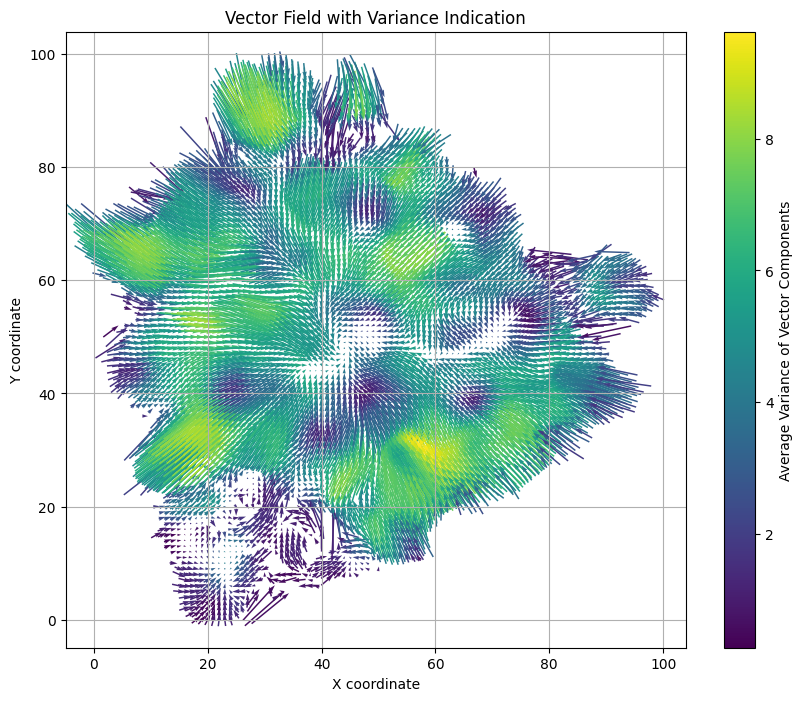

In [5]:
smoothed = process_df(tx, 0,1)
mu_dx,mu_dy,var_dx,var_dy = dataframe_to_grid(smoothed)
mu_dx,mu_dy,var_dx,var_dy = apply_spatial_smoothing(mu_dx,mu_dy,var_dx,var_dy,2)
averaged = grid_to_dataframe(mu_dx,mu_dy,var_dx_grid=var_dx,var_dy_grid=var_dy)
plot_vector_field_with_var(averaged,.7)


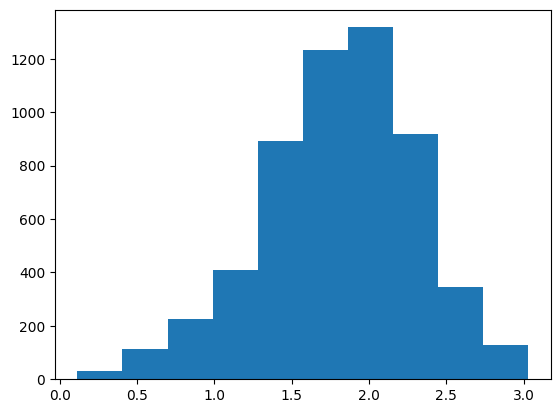

In [208]:
import matplotlib.pyplot as plt
avg_mu = np.sqrt(averaged['mu_dx']**2 + averaged['mu_dy']**2)
plt.hist(np.log1p(avg_mu))
plt.show()
#plot_speed_map(averaged)

## Step 3: Trajectory extraction

In [202]:
averaged

from_x  from_y  mu_dx  mu_dy  var_dx  var_dy  avg_var  avg_mu
0          0       0    NaN    NaN     NaN     NaN      NaN     NaN
1          0       1    NaN    NaN     NaN     NaN      NaN     NaN
2          0       2    NaN    NaN     NaN     NaN      NaN     NaN
3          0       3    NaN    NaN     NaN     NaN      NaN     NaN
4          0       4    NaN    NaN     NaN     NaN      NaN     NaN
...      ...     ...    ...    ...     ...     ...      ...     ...
9995      99      95    NaN    NaN     NaN     NaN      NaN     NaN
9996      99      96    NaN    NaN     NaN     NaN      NaN     NaN
9997      99      97    NaN    NaN     NaN     NaN      NaN     NaN
9998      99      98    NaN    NaN     NaN     NaN      NaN     NaN
9999      99      99    NaN    NaN     NaN     NaN      NaN     NaN

[10000 rows x 8 columns]

## Step 3: Attractor identification

Here, we use the Runge-Kutta algorithm to estimate gradients and plot a flow map.  Note that we add an interpolation step here to enhance the estimate. 

In [322]:
import importlib
import sys
sys.path.append('/home/jeintron/dev/blf_m/blf-attractor-algorithm')
import vector_field_processor
import trajectory_based_analyzer
import trajectory_analysis
importlib.reload(vector_field_processor)
importlib.reload(trajectory_based_analyzer)
importlib.reload(trajectory_analysis)
from vector_field_processor import DiscreteVectorFieldAnalyzer, ForwardTrajectoryAttractorAnalyzer
from trajectory_based_analyzer import TrajectoryBasedAttractorAnalyzer
from trajectory_analysis import TrajectoryAnalysis


In [337]:
analyzer = TrajectoryAnalysis(averaged)
analyzer.compute_trajectories(
    sample_factor = 1,
    solver = "RK45",
    threshold_speed=0.5,
    enforce_interior_endpoints=True,  # This is the key new parameter
    interior_buffer=0.05             # 5% buffer from boundaries
)
#analyzer.compute_trajectories(threshold_speed=0.01, sample_factor=0.3, solver='DOP853')
#analyzer.compute_trajectories(threshold_speed=0.1, sample_factor=0.2)
#analyzer.identify_attractors()


Grid shape: 100 x 100
X range: 0 to 99
Y range: 0 to 99


Computing trajectories with RK45:   0%|          | 0/10000 [00:00<?, ?it/s]


Speed statistics:
  Min: 0.000000
  25th percentile: 0.500000
  Median: 0.500000
  Mean: 0.498978
  75th percentile: 0.500000
  Max: 0.500000

Trajectories computed: 5616 successful, 0 failed
Endpoints: 4 near boundary, 2766 below speed threshold


In [342]:
#analyzer.identify_attractors_from_slowest_regions(distance_threshold=3,percentile_threshold=5)
#analyzer.identify_attractors(distance_threshold=1,min_samples=10, endpoint_slow_percentile=30)
_,confs = analyzer.identify_attractors_hdbscan(min_samples=30,min_cluster_size=5,confidence_factor=0.005)

Confidence scores: min = 0.003, max = 0.643, mean = 0.417
HDBSCAN found 14 clusters and 489 noise points (8.7%)
Attractor 0: 36 points, avg confidence: 0.278
Attractor 1: 104 points, avg confidence: 0.311
Attractor 2: 12 points, avg confidence: 0.288


Attractor 3: 305 points, avg confidence: 0.426
Attractor 4: 437 points, avg confidence: 0.393
Attractor 5: 57 points, avg confidence: 0.269
Attractor 6: 923 points, avg confidence: 0.415
Attractor 7: 2620 points, avg confidence: 0.475
Attractor 8: 195 points, avg confidence: 0.275
Attractor 9: 17 points, avg confidence: 0.262
Attractor 10: 55 points, avg confidence: 0.269
Attractor 11: 106 points, avg confidence: 0.339
Attractor 12: 209 points, avg confidence: 0.345
Attractor 13: 51 points, avg confidence: 0.372


In [343]:
analyzer.assign_basins_to_grid()
#analyzer.fill_basin_interiors(dilation=3)

Basin assignment complete. Grid shape: (100, 100)
Valid data points: 5616
Assigned data points: 5616
  Unassigned: 4384 cells
  Basin 0: 36 cells (0.4%)
  Basin 1: 105 cells (1.1%)
  Basin 2: 14 cells (0.1%)
  Basin 3: 312 cells (3.1%)
  Basin 4: 504 cells (5.0%)
  Basin 5: 58 cells (0.6%)
  Basin 6: 1029 cells (10.3%)
  Basin 7: 2758 cells (27.6%)
  Basin 8: 229 cells (2.3%)
  Basin 9: 31 cells (0.3%)
  Basin 10: 60 cells (0.6%)
  Basin 11: 136 cells (1.4%)
  Basin 12: 254 cells (2.5%)
  Basin 13: 90 cells (0.9%)


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [345]:
analyzer.fill_basin_interiors(iterations=4)

Iteration 1: Filled 180 interior null points
Iteration 2: Filled 48 interior null points
Iteration 3: Filled 23 interior null points
Iteration 4: Filled 16 interior null points
Basin interior filling: 267 null points filled


<Figure size 1200x1000 with 0 Axes>

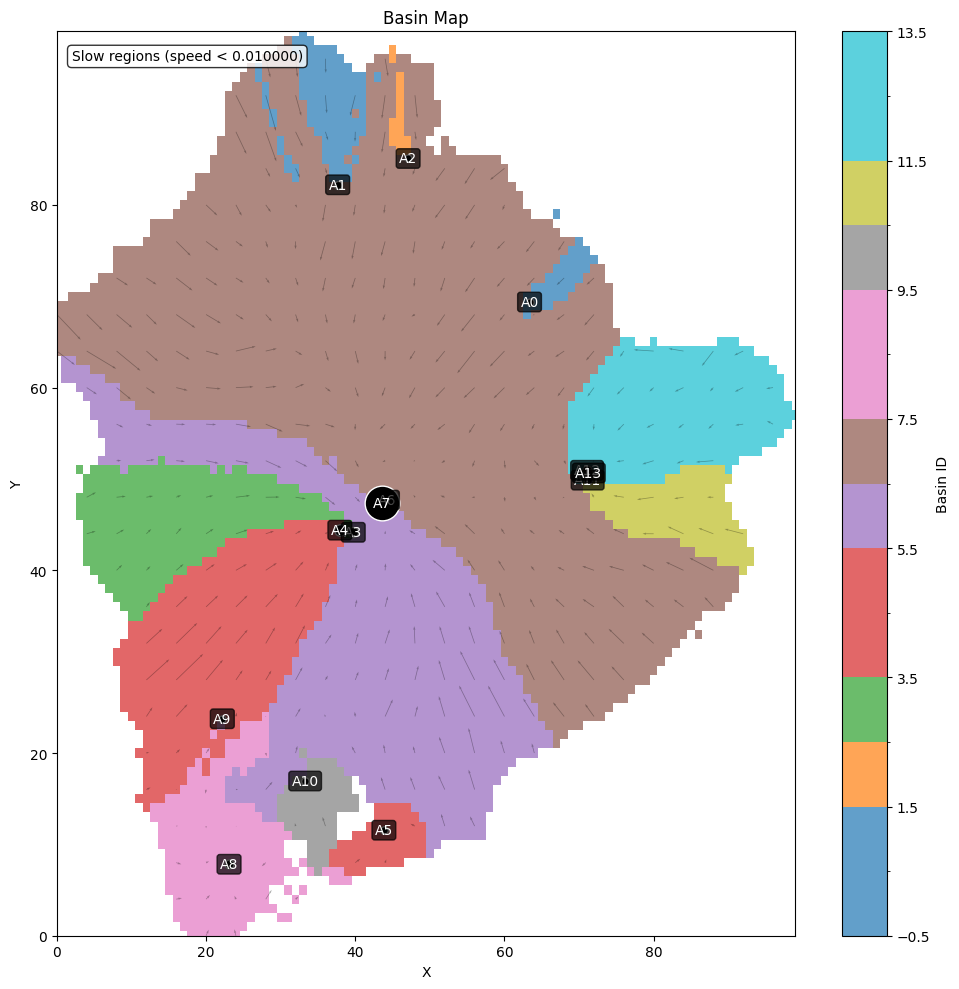

In [346]:
plt.figure(figsize=(12, 10))
analyzer.plot_basin_heatmap(
    cmap='tab10',
    show_attractors=True,
    show_vector_field=True,
    vector_density=4,
    slow_region_threshold=0.01  # Highlight regions slower than this threshold
)
plt.tight_layout()

In [391]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator
from scipy.ndimage import distance_transform_edt, binary_erosion

def enrich_user_data(original_df, trajectory_analyzer, x_col='x', y_col='y', 
                     user_id_col='u_id', time_col='dt'):
    """
    Enrich the original user data with insights from the vector field and basin analysis.
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        Original dataframe with user positions in real coordinates (not grid)
    x_col, y_col : str
        Column names for x and y coordinates in the original dataframe
    user_id_col : str
        Column name for user ID in the original dataframe
    time_col : str
        Column name for timestamp in the original dataframe
    trajectory_analyzer : TrajectoryAnalysis object, optional
        If provided, use the existing analyzer object for vector field operations
        
    Returns:
    --------
    pandas.DataFrame
        Enriched original dataframe with additional columns for basin membership,
        vector field properties, and user dynamics metrics
    """

    basin_grid = trajectory_analyzer.basin_grid

    # Create a copy of the original dataframe
    df_enriched = original_df.copy()
    
    # Get min/max of original coordinates for scaling
    x_orig_min, x_orig_max = df_enriched[x_col].min(), df_enriched[x_col].max()
    y_orig_min, y_orig_max = df_enriched[y_col].min(), df_enriched[y_col].max()
    
   
    
    # Get grid coordinates and dimensions
    x_grid = trajectory_analyzer.x_grid
    y_grid = trajectory_analyzer.y_grid
    nx, ny = len(x_grid), len(y_grid)
    
    # Map original coordinates to grid coordinates for interpolation
    x_norm = (df_enriched[x_col] - x_orig_min) / (x_orig_max - x_orig_min)
    y_norm = (df_enriched[y_col] - y_orig_min) / (y_orig_max - y_orig_min)
    df_enriched['x_grid_float'] = x_norm * (nx - 1)
    df_enriched['y_grid_float'] = y_norm * (ny - 1)
    df_enriched['x_grid'] = df_enriched['x_grid_float'].astype(int).clip(0, nx-1)
    df_enriched['y_grid'] = df_enriched['y_grid_float'].astype(int).clip(0, ny-1)
    
    # Get vector field components and create interpolators
    U = trajectory_analyzer.U
    V = trajectory_analyzer.V
    var_U = trajectory_analyzer.var_U
    var_V = trajectory_analyzer.var_V
    magnitude = np.sqrt(U**2 + V**2)
    
    u_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), U, 
                                      bounds_error=False, fill_value=np.nan)
    v_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), V, 
                                      bounds_error=False, fill_value=np.nan)
    var_u_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), var_U, 
                                          bounds_error=False, fill_value=np.nan)
    var_v_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), var_V, 
                                          bounds_error=False, fill_value=np.nan)
    speed_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), magnitude, 
                                          bounds_error=False, fill_value=np.nan)
    
    # Calculate basin metrics (center, average speed, convergence)
    basin_metrics = {}
    basin_centers = {}
    unique_basins = np.unique(basin_grid[basin_grid >= 0])
    
    for basin_id in unique_basins:
        basin_mask = (basin_grid == basin_id)
        y_indices, x_indices = np.where(basin_mask)
        attractor = trajectory_analyzer.attractors[basin_id]
        


        # Use the attractor location
        center_y = attractor['position'][0]
        center_x = attractor['position'][1]
        basin_centers[basin_id] = (center_x, center_y)
        
        # Calculate average speed in basin
        basin_speeds = magnitude[basin_mask]
        avg_speed = np.mean(basin_speeds) if len(basin_speeds) > 0 else np.nan
        
        # Calculate convergence (whether vectors point toward or away from center)
        convergence_sum = 0
        count = 0
        
        for i, j in zip(x_indices, y_indices):
            if i < nx and j < ny and not np.isnan(U[i, j]) and not np.isnan(V[i, j]):
                # Vector from this point to center
                dx_to_center = center_x - i
                dy_to_center = center_y - j
                
                # Vector field at this point
                u_val = U[i, j]
                v_val = V[i, j]
                
                # Calculate dot product (positive if pointing toward center)
                if dx_to_center != 0 or dy_to_center != 0:
                    # Normalize the center vector
                    center_mag = np.sqrt(dx_to_center**2 + dy_to_center**2)
                    dx_to_center /= center_mag
                    dy_to_center /= center_mag
                    
                    # Dot product with vector field
                    dot_product = u_val * dx_to_center + v_val * dy_to_center
                    convergence_sum += dot_product
                    count += 1
        
        # Calculate average convergence (-1 to 1, positive means attraction)
        avg_convergence = convergence_sum / count if count > 0 else 0
        
        # Store metrics for this basin
        basin_metrics[basin_id] = {
            'avg_speed': avg_speed,
            'convergence': avg_convergence,
            'size': np.sum(basin_mask),
            'center': (center_x, center_y)
        }
    
    # Calculate distance to basin edge for each basin
    basin_distance_maps = {}
    
    for basin_id in unique_basins:
        basin_mask = (basin_grid == basin_id)
        basin_edge = basin_mask & ~binary_erosion(basin_mask)
        distance_from_edge = distance_transform_edt(~basin_edge)
        distance_from_edge[~basin_mask] = 0
        basin_distance_maps[basin_id] = distance_from_edge
    
    # Create combined distance map and interpolator
    combined_distance_map = np.zeros_like(basin_grid, dtype=float)
    for basin_id, distance_map in basin_distance_maps.items():
        combined_distance_map[basin_grid == basin_id] = distance_map[basin_grid == basin_id]
    
    distance_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), combined_distance_map, 
                                            bounds_error=False, fill_value=0)
    
    # Create nearest-neighbor interpolator for basin assignment
    points = []
    basins = []
    for i in range(nx):
        for j in range(ny):
            if basin_grid[i, j] >= 0:
                points.append((i, j))
                basins.append(basin_grid[i, j])
    
    if points:
        basin_interp = NearestNDInterpolator(points, basins)
    else:
        basin_interp = lambda coords: np.full(len(coords), -1)
    
    # Apply interpolators to original data points
    coords = np.column_stack((df_enriched['x_grid_float'], df_enriched['y_grid_float']))
    
    # Apply vector field interpolators
    df_enriched['mu_dx'] = u_interp(coords)
    df_enriched['mu_dy'] = v_interp(coords)
    df_enriched['var_dx'] = var_u_interp(coords)
    df_enriched['var_dy'] = var_v_interp(coords)
    df_enriched['speed'] = speed_interp(coords)
    
    # Apply basin assignment and distance interpolators
    basin_assignments = []
    distances_to_edge = []
    
    for i, (x, y) in enumerate(coords):
        basin = basin_interp([[x, y]])[0]
        basin_assignments.append(basin)
        distance = distance_interp([[x, y]])[0]
        distances_to_edge.append(distance)
    
    df_enriched['basin_id'] = basin_assignments
    df_enriched['dist_to_edge'] = distances_to_edge
    
    # Calculate normalized distance to edge
    df_enriched['norm_dist_to_edge'] = np.nan
    
    for basin_id in unique_basins:
        max_dist = np.max(basin_distance_maps[basin_id])
        mask = df_enriched['basin_id'] == basin_id
        if max_dist > 0:
            df_enriched.loc[mask, 'norm_dist_to_edge'] = df_enriched.loc[mask, 'dist_to_edge'] / max_dist
    
    # Calculate distance to basin center
    df_enriched['dist_to_center'] = np.nan
    
    for basin_id, center in basin_centers.items():
        mask = df_enriched['basin_id'] == basin_id
        center_x, center_y = center
        
        x_coords = df_enriched.loc[mask, 'x_grid_float']
        y_coords = df_enriched.loc[mask, 'y_grid_float']
        
        df_enriched.loc[mask, 'dist_to_center'] = np.sqrt(
            (x_coords - center_x)**2 + (y_coords - center_y)**2
        )
    
    # Add basin metrics to dataframe
    df_enriched['basin_avg_speed'] = np.nan
    df_enriched['basin_convergence'] = np.nan
    df_enriched['basin_size'] = np.nan
    
    for basin_id, metrics in basin_metrics.items():
        mask = df_enriched['basin_id'] == basin_id
        df_enriched.loc[mask, 'basin_avg_speed'] = metrics['avg_speed']
        df_enriched.loc[mask, 'basin_convergence'] = metrics['convergence']
        df_enriched.loc[mask, 'basin_size'] = metrics['size']
    
    # Add user movement metrics
    df_enriched = df_enriched.sort_values([user_id_col, time_col])
    
    # Calculate basin changes
    df_enriched['prev_basin'] = df_enriched.groupby(user_id_col)['basin_id'].shift(1)
    df_enriched['basin_change'] = (df_enriched['basin_id'] != df_enriched['prev_basin']).astype(int)
    df_enriched.loc[df_enriched['prev_basin'].isna(), 'basin_change'] = 0

    # TODO:  This is the the first edit
    ############
    ############  Block for transition
    ############
    # Process each user to calculate transition confidence and basin belief
        # Calculate transition confidence (soft boundary)
    df_enriched['transition_confidence'] = 0.0
    df_enriched['basin_belief'] = 0.0
    df_enriched['cumulative_basin_belief'] = 0.0
    
    # Process each user to calculate transition confidence and basin belief
    for user_id, user_data in df_enriched.groupby(user_id_col):
        user_idx = user_data.index
        user_data_sorted = user_data.sort_values(time_col)
        
        # Variables to track belief about which basin the user is in
        current_basin = -1
        basin_belief = 0.0
        transition_confidences = []
        basin_beliefs = []
        time_in_basin = []  # Track how many observations the user has had in current basin
        
        # Parameters for Bayesian updating
        prior_weight = 0.8     # Weight for prior belief
        evidence_weight = 0.2  # Weight for new evidence
        
        # Calculate transition confidence and basin belief
        for i, (idx, row) in enumerate(user_data_sorted.iterrows()):
            basin_id = row['basin_id']
            dist_to_edge = row['norm_dist_to_edge'] if not np.isnan(row['norm_dist_to_edge']) else 0.0
            
            # Handle basin changes
            if basin_id != current_basin and basin_id != -1:
                # Basin transition detected
                
                # Calculate transition confidence - how confident are we this is a real transition?
                # Low when close to basin edge or junction, high when far from edges and junctions
                if 'distance_to_junction' in row and not np.isnan(row['distance_to_junction']):
                    # Include junction distance in the calculation
                    junction_distance = row['norm_distance_to_junction']
                    transition_confidence = 0.5 * dist_to_edge + 0.5 * junction_distance
                else:
                    # Just use distance from edge if junction distance not available
                    transition_confidence = dist_to_edge
                
                # Reset belief for new basin
                basin_belief = dist_to_edge  # Initial belief proportional to distance in
                current_basin = basin_id
                current_time = 1  # Reset time counter
                
            elif basin_id == current_basin:
                # Still in same basin - update belief with Bayesian update
                # Evidence strength based on distance from edge
                evidence = dist_to_edge
                
                # Calculate updated belief with Bayesian-inspired formula
                basin_belief = (prior_weight * basin_belief + 
                               evidence_weight * evidence)
                
                # Transition confidence is high when staying in same basin
                transition_confidence = 0.95  # High confidence when not transitioning
                current_time += 1
                
            else:
                # No assigned basin
                transition_confidence = 0.0
                basin_belief = 0.0
                current_basin = -1
                current_time = 0
            
            # Store results
            transition_confidences.append(transition_confidence)
            basin_beliefs.append(basin_belief)
            time_in_basin.append(current_time)
        
        # Assign values back to the main dataframe
        df_enriched.loc[user_idx, 'transition_confidence'] = transition_confidences
        df_enriched.loc[user_idx, 'basin_belief'] = basin_beliefs
        df_enriched.loc[user_idx, 'time_in_basin'] = time_in_basin



    
    # Calculate position changes
    df_enriched['delta_x'] = df_enriched.groupby(user_id_col)[x_col].diff()
    df_enriched['delta_y'] = df_enriched.groupby(user_id_col)[y_col].diff()
    df_enriched['movement_magnitude'] = np.sqrt(df_enriched['delta_x']**2 + df_enriched['delta_y']**2)
    
    # Calculate time differences
    if pd.api.types.is_datetime64_any_dtype(df_enriched[time_col]):
        df_enriched['time_diff'] = df_enriched.groupby(user_id_col)[time_col].diff().dt.total_seconds()
    else:
        df_enriched['time_diff'] = df_enriched.groupby(user_id_col)[time_col].diff()
    
    # Calculate user speed
    df_enriched['user_speed'] = df_enriched['movement_magnitude'] / df_enriched['time_diff']


        # Calculate entropy of basin appearances for each user
    user_entropies = {}
    for user_id, user_data in df_enriched.groupby(user_id_col):
        # Get basin counts, excluding -1 (non-assigned)
        basin_counts = user_data[user_data['basin_id'] >= 0]['basin_id'].value_counts()
        total_appearances = basin_counts.sum()
        
        if total_appearances > 0:
            # Calculate probabilities
            basin_probs = basin_counts / total_appearances
            # Calculate entropy
            entropy = -np.sum(basin_probs * np.log2(basin_probs))
            user_entropies[user_id] = entropy
        else:
            user_entropies[user_id] = 0.0
    
    df_enriched['user_basin_entropy'] = df_enriched[user_id_col].map(user_entropies)
    
    # Add user stability metrics
    user_basin_changes = df_enriched.groupby(user_id_col)['basin_change'].sum()
    user_total_moves = df_enriched.groupby(user_id_col).size() - 1
    user_change_rate = user_basin_changes / user_total_moves.clip(lower=1)  # Avoid division by zero
    
    df_enriched['user_basin_changes'] = df_enriched[user_id_col].map(user_basin_changes)
    df_enriched['user_total_moves'] = df_enriched[user_id_col].map(user_total_moves)
    df_enriched['user_change_rate'] = df_enriched[user_id_col].map(user_change_rate)
    
    # Calculate user's average speed and movement
    user_avg_speed = df_enriched.groupby(user_id_col)['user_speed'].mean()
    user_avg_movement = df_enriched.groupby(user_id_col)['movement_magnitude'].mean()
    
    df_enriched['user_avg_speed'] = df_enriched[user_id_col].map(user_avg_speed)
    df_enriched['user_avg_movement'] = df_enriched[user_id_col].map(user_avg_movement)
    
    # Calculate a "stability index" for each user (low values = stable, high values = unstable)
    stability_index = (
        (user_change_rate / user_change_rate.mean()) * 0.5 +
        (user_avg_speed / user_avg_speed.mean()) * 0.5
    )
    df_enriched['user_stability_index'] = df_enriched[user_id_col].map(stability_index)
    
    return df_enriched

def analyze_basin_transitions(enriched_df, user_id_col='u_id', time_col='dt'):
    """
    Analyze basin transitions to identify common transition patterns
    and transition probabilities between basins.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Dataframe with basin assignments and user movement data
    user_id_col : str
        Column name for user ID
    time_col : str
        Column name for timestamp
        
    Returns:
    --------
    tuple
        (transition_matrix, transition_counts) 
        Transition probability matrix and raw counts for basin transitions
    """
    # Make sure data is properly sorted
    df = enriched_df.sort_values([user_id_col, time_col])
    
    # Get unique basin IDs, excluding -1 (non-assigned)
    unique_basins = sorted(df['basin_id'].unique())
    if -1 in unique_basins:
        unique_basins.remove(-1)
    
    n_basins = len(unique_basins)
    
    # Initialize transition matrix and counts
    transition_counts = pd.DataFrame(0, index=unique_basins, columns=unique_basins)
    
    # Count transitions for each user
    for user_id, user_data in df.groupby(user_id_col):
        # Get sequence of basins for this user, exclude -1
        basin_seq = user_data['basin_id'].values
        
        # Count transitions
        for i in range(len(basin_seq) - 1):
            # Skip transitions involving -1
            if basin_seq[i] == -1 or basin_seq[i+1] == -1:
                continue
                
            # # Skip self-transitions (staying in same basin)
            # if basin_seq[i] == basin_seq[i+1]:
            #     continue
                
            # Count this transition
            transition_counts.loc[basin_seq[i], basin_seq[i+1]] += 1
    
    # Calculate transition probabilities
    row_sums = transition_counts.sum(axis=1)
    transition_probs = transition_counts.copy()
    
    for i, basin in enumerate(unique_basins):
        if row_sums[basin] > 0:
            transition_probs.loc[basin] = transition_counts.loc[basin] / row_sums[basin]
    
    return transition_probs, transition_counts

def predict_basin_transition(user_data, transition_probs, features=None):
    """
    Predict whether a user is likely to transition to a different basin
    based on their current position and basin transition probabilities.
    
    Parameters:
    -----------
    user_data : pandas.DataFrame
        Data for a single user with enriched basin features
    transition_probs : pandas.DataFrame
        Basin transition probability matrix
    features : list
        List of features to use for prediction
        
    Returns:
    --------
    tuple
        (prediction, confidence) 
        Boolean prediction and confidence score
    """
    from sklearn.ensemble import RandomForestClassifier
    
    if features is None:
        features = [
            'dist_to_edge', 'norm_dist_to_edge', 'speed', 
            'basin_convergence', 'user_change_rate'
        ]
    
    # Get the user's current basin
    current_basin = user_data['basin_id'].iloc[-1]
    
    # If not in a valid basin, can't make prediction
    if current_basin == -1:
        return False, 0.0
    
    # Calculate transition probability based on basin transitions
    if current_basin in transition_probs.index:
        # Get transition probabilities from this basin to others
        probs = transition_probs.loc[current_basin]
        total_trans_prob = probs.sum()  # Sum of all transition probabilities
    else:
        total_trans_prob = 0.0
    
    # Get latest feature values
    latest_data = user_data.iloc[-1]
    
    # Factors that increase transition likelihood
    near_edge = latest_data['norm_dist_to_edge'] < 0.2  # Close to basin edge
    high_speed = latest_data['speed'] > latest_data['basin_avg_speed'] * 1.2  # Moving faster than basin average
    low_convergence = latest_data['basin_convergence'] < 0  # Vectors pointing outward
    
    # Combine factors (simple weighted approach)
    edge_weight = 0.4
    speed_weight = 0.3
    convergence_weight = 0.2
    history_weight = 0.1
    
    transition_score = (
        edge_weight * (1 if near_edge else 0) +
        speed_weight * (1 if high_speed else 0) +
        convergence_weight * (1 if low_convergence else 0) +
        history_weight * min(1.0, latest_data['user_change_rate'] * 2)  # Scale user change rate
    )
    
    # Combine with historical transition probability
    final_score = 0.7 * transition_score + 0.3 * total_trans_prob
    
    # Make prediction (threshold at 0.5)
    prediction = final_score > 0.5
    
    return prediction, final_score

In [392]:
enriched_df = enrich_user_data(trace,analyzer)

In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

def combined_cmap(n):
    """Combine multiple colormaps to get more distinct colors"""
    # Use qualitative colormaps
    cmaps = ['tab10', 'Set3', 'Dark2', 'Paired']
    colors = []
    
    for cmap_name in cmaps:
        cmap = plt.cm.get_cmap(cmap_name)
        n_colors = min(10, cmap.N)  # Most have 8-10 colors
        colors.extend([cmap(i) for i in range(n_colors)])
    
    # Take as many as needed
    return ListedColormap(colors[:n])

def plot_transitions_on_basin_map(enriched_df,transition_analyzer=None, 
                                figsize=(12, 10), alpha_basins=0.7, 
                                transition_cmap='hot_r', show_attractors=True, dest=None):
    """
    Visualize basin transitions on top of the basin map with consistent orientation.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    basin_grid : numpy.ndarray
        2D array of basin assignments for each grid cell
    transition_analyzer : TrajectoryAnalysis object, optional
        If provided, attractor information will be used for annotation
    figsize : tuple
        Figure size (width, height)
    alpha_basins : float
        Transparency of the basin colors
    transition_cmap : str
        Colormap for transition heatmap
    show_attractors : bool
        Whether to show attractor markers
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    basin_grid = transition_analyzer.basin_grid

    fig, ax = plt.subplots(figsize=figsize)
    
    # Get grid dimensions
    nx, ny = basin_grid.shape
    
    # Create a mask for areas with no basin
    no_basin_mask = (basin_grid == -1)
    
    # Create a copy of the basin grid for visualization
    vis_grid = basin_grid.copy()
    
    # Count unique basins (excluding -1)
    unique_basins = np.unique(vis_grid[vis_grid >= 0])
    n_basins = len(unique_basins)
    
    # Create coordinate grids - these ensure the proper orientation
    x_coords = np.arange(0, nx)
    y_coords = np.arange(0, ny)
    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
    
    if n_basins > 0:
        basin_cmap = combined_cmap(n_basins)
        
        # Create a normalized colormap
        norm = mcolors.BoundaryNorm(np.arange(-0.5, n_basins + 0.5), basin_cmap.N)
        
        # Replace -1 with masked value for visualization
        vis_grid = np.ma.masked_where(no_basin_mask, vis_grid)
        
        # Plot the basin heatmap
        basin_plot = ax.pcolormesh(X, Y, vis_grid, cmap=basin_cmap, norm=norm, 
                                alpha=alpha_basins, shading='auto')
        
        # Add a colorbar for basins
        cbar_basins = plt.colorbar(basin_plot, ax=ax, location='right', pad=0.01)
        cbar_basins.set_label('Basin ID')
    else:
        print("No basins found to visualize.")
    
    # Now plot transitions on top
    
    # Aggregate transitions by grid cell
    # Create pivot table of grid positions and transitions


    x_col = "x_grid"
    y_col = "y_grid"
    enriched_df=enriched_df.copy()
    enriched_df[["x_prev","y_prev"]] = enriched_df.groupby("u_id")[["x_grid","y_grid"]].shift(1, fill_value=-1)
    if dest != None:
        enriched_df = enriched_df[enriched_df.basin_id == dest]
        x_col = "x_prev"
        y_col = "y_prev"



    pivot_df = pd.pivot_table(
        enriched_df,
        values='basin_change',
        index=x_col,
        columns=y_col,
        aggfunc='sum',
        fill_value=0
    )
    
    # Convert to numpy array with correct orientation
    transition_grid = np.zeros((nx, ny))
    for x in pivot_df.index:
        for y in pivot_df.columns:
            if 0 <= x < nx and 0 <= y < ny:
                transition_grid[x, y] = pivot_df.loc[x, y]
            
    
    # Plot transitions
    if np.max(transition_grid) > 0:
        # Use a different colormap for transitions
        transition_map = ax.pcolormesh(
            X, Y, transition_grid, 
            cmap=transition_cmap, 
            alpha=0.7 * (transition_grid > 0),  # Only show non-zero cells
            shading='auto'
        )
        
        # Add colorbar for transitions
        cbar_trans = plt.colorbar(transition_map, ax=ax, location='left', pad=0.01)
        cbar_trans.set_label('Transition Count')
    
    # Show attractors if requested and available
    if show_attractors and transition_analyzer is not None and hasattr(transition_analyzer, 'attractors'):
        for label, attractor in transition_analyzer.attractors.items():
            pos = attractor['position']
            size = attractor['size']
            
            # Scale marker size by the basin size
            marker_size = 10 + 30 * (size / max(1, max(att['size'] for att in transition_analyzer.attractors.values())))
            
            ax.plot(pos[0], pos[1], 'o', markersize=marker_size, 
                   color='white', markeredgecolor='black', alpha=0.8)
            
            # Add label
            ax.text(pos[0], pos[1], f'A{label}', fontsize=12, 
                   ha='center', va='center', color='black', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Set axis limits and labels
    ax.set_xlim(-0.5, nx - 0.5)
    ax.set_ylim(-0.5, ny - 0.5)
    ax.set_xlabel('Grid X')
    ax.set_ylabel('Grid Y')
    ax.set_title('Basin Map with Transition Overlay')
    
    return fig

def plot_transition_features(enriched_df, feature_x, feature_y='basin_change', 
                           figsize=(10, 8), plot_type='scatter'):
    """
    Plot relationships between transition-related features.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    feature_x : str
        Feature to plot on x-axis
    feature_y : str
        Feature to plot on y-axis, defaults to 'basin_change'
    figsize : tuple
        Figure size (width, height)
    plot_type : str
        Type of plot ('scatter', 'hexbin', 'kde', or 'violin')
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_type == 'scatter':
        # Color points by whether a transition occurred
        colors = np.where(enriched_df['basin_change'] > 0, 'red', 'blue')
        sizes = np.where(enriched_df['basin_change'] > 0, 50, 20)  # Larger points for transitions
        
        # Create a scatter plot
        scatter = ax.scatter(
            enriched_df[feature_x], 
            enriched_df[feature_y], 
            c=colors, 
            s=sizes,
            alpha=0.5
        )
        
        # Add a legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Transition'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='No Transition')
        ]
        ax.legend(handles=legend_elements)
        
    elif plot_type == 'hexbin':
        # Create a hexbin plot
        hb = ax.hexbin(
            enriched_df[feature_x], 
            enriched_df[feature_y], 
            gridsize=30, 
            cmap='viridis', 
            mincnt=1
        )
        plt.colorbar(hb, ax=ax, label='Count')
        
    elif plot_type == 'kde':
        # Create kernel density plots
        transitions = enriched_df[enriched_df['basin_change'] > 0]
        non_transitions = enriched_df[enriched_df['basin_change'] == 0]
        
        sns.kdeplot(
            data=transitions, 
            x=feature_x, 
            ax=ax, 
            color='red', 
            label='Transitions'
        )
        sns.kdeplot(
            data=non_transitions, 
            x=feature_x, 
            ax=ax, 
            color='blue', 
            label='No Transitions'
        )
        ax.legend()
        
    elif plot_type == 'violin':
        # Create a dataframe for the violin plot
        plot_df = enriched_df.copy()
        plot_df['transition'] = np.where(plot_df['basin_change'] > 0, 'Yes', 'No')
        
        # Create a violin plot
        sns.violinplot(
            data=plot_df, 
            x='transition', 
            y=feature_x, 
            ax=ax,
            palette={'Yes': 'red', 'No': 'blue'}
        )
    
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y if plot_type != 'violin' and plot_type != 'kde' else 'Density')
    ax.set_title(f'Relationship between {feature_x} and Transitions')
    
    return fig



/tmp/ipykernel_1644527/2213742163.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


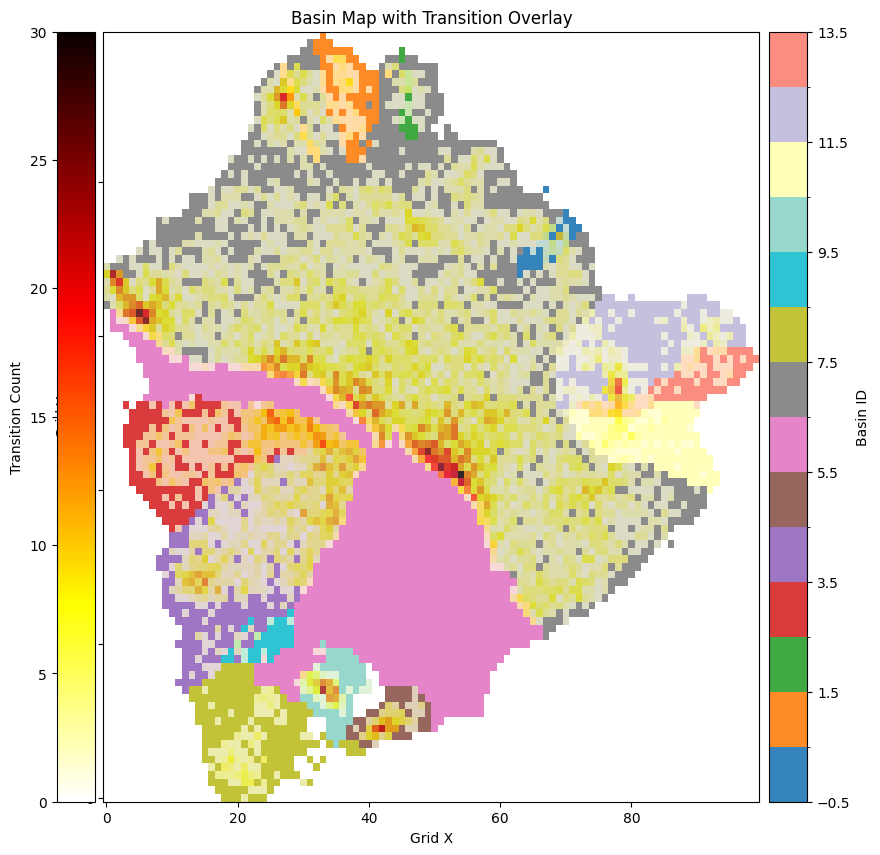

In [436]:
plot_transitions_on_basin_map(enriched_df,analyzer,alpha_basins=0.9,show_attractors=False,dest=6)
plt.show()

In [438]:
enriched_df.columns


Index(['x', 'y', 'dt', 'u_id', 'clust_labels', 'botscore', 'x_grid_float',
       'y_grid_float', 'x_grid', 'y_grid', 'mu_dx', 'mu_dy', 'var_dx',
       'var_dy', 'speed', 'basin_id', 'dist_to_edge', 'norm_dist_to_edge',
       'dist_to_center', 'basin_avg_speed', 'basin_convergence', 'basin_size',
       'prev_basin', 'basin_change', 'transition_confidence', 'basin_belief',
       'cumulative_basin_belief', 'time_in_basin', 'delta_x', 'delta_y',
       'movement_magnitude', 'time_diff', 'user_speed', 'user_basin_entropy',
       'user_basin_changes', 'user_total_moves', 'user_change_rate',
       'user_avg_speed', 'user_avg_movement', 'user_stability_index'],
      dtype='object')

In [453]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from scipy import interpolate
from scipy import ndimage
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import datetime

def find_basin_boundaries(basin_grid):
    """
    Find the boundaries of each basin in a grid.
    
    Parameters:
    -----------
    basin_grid : numpy.ndarray
        2D array with basin assignments
        
    Returns:
    --------
    dict
        Dictionary mapping basin_id to boundary coordinates
    """
    from skimage import measure
    
    boundaries = {}
    unique_basins = np.unique(basin_grid)
    
    for basin_id in unique_basins:
        if basin_id == -1:  # Skip unassigned areas
            continue
            
        # Create binary mask for this basin
        basin_mask = (basin_grid == basin_id)
        
        try:
            # Find contours at the 0.5 level (boundary between 0 and 1)
            contours = measure.find_contours(basin_mask.astype(float), 0.5)
            
            if contours:
                # Sort contours by length, keep the longest one(s)
                contours = sorted(contours, key=lambda x: len(x), reverse=True)
                
                # IMPORTANT: Swap coordinates to match the original grid orientation
                # Each contour has (row, col) coordinates, but we need (x, y) = (col, row)
                swapped_contour = np.column_stack((contours[0][:, 1], contours[0][:, 0]))
                boundaries[basin_id] = swapped_contour
                
                # If there are multiple significant contours, process them separately
                if len(contours) > 1:
                    main_contour_length = len(contours[0])
                    for i in range(1, min(len(contours), 3)):  # Limit to top 3 contours
                        if len(contours[i]) > main_contour_length * 0.3:  # More permissive threshold
                            # Swap coordinates and store 
                            swapped_part = np.column_stack((contours[i][:, 1], contours[i][:, 0]))
                            boundaries[f"{basin_id}_part{i}"] = swapped_part
        except Exception as e:
            print(f"Error finding boundary for basin {basin_id}: {str(e)}")
            continue
    
    return boundaries

def smooth_boundary(boundary, smoothing_factor=0.5):
    """
    Apply smoothing to a basin boundary using spline interpolation.
    
    Parameters:
    -----------
    boundary : numpy.ndarray
        Array of (x, y) coordinates defining the boundary
    smoothing_factor : float
        Controls the smoothness of the spline
        
    Returns:
    --------
    numpy.ndarray
        Smoothed boundary coordinates
    """
    # Need at least 4 points for cubic spline
    if len(boundary) < 4:
        return boundary
    
    try:
        # Non-periodic smoothing approach (more robust)
        # Create a parameter along the boundary
        t = np.arange(len(boundary))
        
        # Check if points are unique - if not, add tiny noise
        if len(np.unique(boundary, axis=0)) < len(boundary):
            boundary += np.random.normal(0, 1e-6, boundary.shape)
        
        # Fit a spline to x and y coordinates separately
        x = boundary[:, 0]
        y = boundary[:, 1]
        
        # Use UnivariateSpline for more robust smoothing
        x_spl = interpolate.UnivariateSpline(t, x, k=3, s=len(x)*smoothing_factor)
        y_spl = interpolate.UnivariateSpline(t, y, k=3, s=len(y)*smoothing_factor)
        
        # Generate more points for a smoother curve
        t_new = np.linspace(0, len(boundary) - 1, 4 * len(boundary))
        smooth_x = x_spl(t_new)
        smooth_y = y_spl(t_new)
        
        smooth_boundary = np.column_stack((smooth_x, smooth_y))
        
        # Close the loop by repeating the first point
        smooth_boundary = np.vstack([smooth_boundary, smooth_boundary[0]])
        
        return smooth_boundary
        
    except Exception as e:
        print(f"Smoothing failed for boundary with {len(boundary)} points. Using original boundary.")
        print(f"Error: {str(e)}")
        return boundary

def find_basin_centers(basin_grid):
    """
    Find the centers of each basin for label placement.
    Uses distance transform to find the point furthest from the boundary.
    
    Parameters:
    -----------
    basin_grid : numpy.ndarray
        2D array with basin assignments
        
    Returns:
    --------
    dict
        Dictionary mapping basin_id to center coordinates (x, y)
    """
    from scipy.ndimage import distance_transform_edt
    
    centers = {}
    unique_basins = np.unique(basin_grid)
    
    for basin_id in unique_basins:
        if basin_id == -1:  # Skip unassigned areas
            continue
            
        # Create binary mask for this basin
        basin_mask = (basin_grid == basin_id)
        
        # Skip very small basins
        if np.sum(basin_mask) < 5:
            continue
            
        # Compute distance transform
        distance = distance_transform_edt(basin_mask)
        
        # Find the coordinates of the maximum distance
        center_idx = np.unravel_index(np.argmax(distance), distance.shape)
        
        # Convert from (row, col) to (x, y) format
        # IMPORTANT: Swap coordinates for consistent orientation
        centers[basin_id] = (center_idx[1], center_idx[0])
    
    return centers

def plot_enhanced_basin_map(enriched_df, transition_analyzer, 
                           figsize=(14, 12), transition_cmap='hot_r',
                           show_attractors=False, dest=None,
                           min_date=None, max_date=None, kde_bins=100,
                           boundary_smoothing=0.5, basin_label_fontsize=10,
                           basin_boundary_color='blue', basin_boundary_width=1.5):
    """
    Create an enhanced visualization with KDE background, smooth basin boundaries,
    and transition overlays with optional date filtering.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    transition_analyzer : TrajectoryAnalysis object
        Trajectory analyzer object with basin information
    figsize : tuple
        Figure size (width, height)
    transition_cmap : str
        Colormap for transition heatmap
    show_attractors : bool
        Whether to show attractor markers
    dest : int, optional
        If provided, only show transitions to this destination basin
    min_date : datetime or str, optional
        Minimum date for filtering transitions
    max_date : datetime or str, optional
        Maximum date for filtering transitions
    kde_bins : int
        Number of bins for the KDE
    boundary_smoothing : float
        Controls the smoothness of basin boundaries
    basin_label_fontsize : int
        Font size for basin labels
    basin_boundary_color : str
        Color for basin boundaries
    basin_boundary_width : float
        Line width for basin boundaries
    swap_axes : bool
        If True, swap x and y axes for all elements (helps fix orientation issues)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get basin grid from transition_analyzer
    basin_grid = transition_analyzer.basin_grid
    
    # Get grid dimensions
    nrows, ncols = basin_grid.shape
    
    # Create KDE of all data points as background
    # Ensure x_grid_float and y_grid_float are available
    if 'x_grid_float' in enriched_df.columns and 'y_grid_float' in enriched_df.columns:
        # Create a grayscale KDE - using Greys_r for lighter in higher density areas
        kde_data = enriched_df[['x_grid_float', 'y_grid_float']].dropna()
        
        # Handle axis swapping if needed
        x_var = 'y_grid_float'#if swap_axes else 'x_grid_float'
        y_var = 'x_grid_float' #if swap_axes else 'y_grid_float'
        
        # Use Seaborn's kdeplot for a nicer KDE with inverted colormap
        sns.kdeplot(
            data=kde_data,
            x=x_var, y=y_var,
            fill=True, cmap='Greys_r',  # Using _r suffix for reversed colormap
            levels=15, thresh=0.05,
            ax=ax, alpha=0.7,
            bw_adjust=0.8
        )
    else:
        print("Warning: x_grid_float or y_grid_float columns not found. Skipping KDE background.")
    
    # Find basin boundaries
    boundaries = find_basin_boundaries(basin_grid)
    
    # Find basin centers for labeling
    centers = find_basin_centers(basin_grid)
    
    # Plot smooth basin boundaries
    for basin_id, boundary in boundaries.items():
        try:
            # Smooth the boundary
            smooth_boundary_coords = smooth_boundary(boundary, smoothing_factor=boundary_smoothing)
            
            # Plot the smoothed boundary
            label = None
            if isinstance(basin_id, str) and "_part" in basin_id:
                # This is a secondary contour, use the same color but no label
                base_id = basin_id.split("_part")[0]
                ax.plot(smooth_boundary_coords[:, 0], smooth_boundary_coords[:, 1], 
                       color=basin_boundary_color, linewidth=basin_boundary_width, alpha=0.8)
            else:
                # This is a primary contour, add label if it's the first one
                if basin_id == next(iter([k for k in boundaries.keys() if not isinstance(k, str) or "_part" not in k]), None):
                    label = "Basin Boundaries"
                ax.plot(smooth_boundary_coords[:, 0], smooth_boundary_coords[:, 1], 
                       color=basin_boundary_color, linewidth=basin_boundary_width, alpha=0.8,
                       label=label)
        except Exception as e:
            print(f"Error plotting boundary for basin {basin_id}: {str(e)}")
        
        # Add basin label at center
        if basin_id in centers:
            center_x, center_y = centers[basin_id]
            ax.text(center_x, center_y, f"{basin_id}", 
                   ha='center', va='center', fontsize=basin_label_fontsize,
                   fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, 
                                              boxstyle='round,pad=0.3'))
    
    # Filter transitions by date if requested
    filtered_df = enriched_df.copy()
    if min_date is not None or max_date is not None:
        if 'dt' in filtered_df.columns:
            # Convert min_date and max_date to datetime if they're strings
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            if isinstance(max_date, str):
                max_date = pd.to_datetime(max_date)
            
            # Apply date filters
            if min_date is not None:
                filtered_df = filtered_df[filtered_df['dt'] >= min_date]
            if max_date is not None:
                filtered_df = filtered_df[filtered_df['dt'] <= max_date]
                
            print(f"Filtered transitions from {len(enriched_df)} to {len(filtered_df)} rows.")
        else:
            print("Warning: 'dt' column not found. Cannot filter by date.")
    
    # Prepare for transition plotting
    x_col = "x_grid"
    y_col = "y_grid"
    filtered_df = filtered_df.copy()
    filtered_df[["x_prev", "y_prev"]] = filtered_df.groupby("u_id")[["x_grid", "y_grid"]].shift(1, fill_value=-1)
    
    # Filter to specific destination basin if requested
    if dest is not None:
        filtered_df = filtered_df[filtered_df.basin_id == dest]
        x_col = "x_prev"
        y_col = "y_prev"
        title_suffix = f" (Transitions to Basin {dest})"
    else:
        title_suffix = " (All Transitions)"
    
    # Create transition heatmap
    try:
        pivot_df = pd.pivot_table(
            filtered_df[filtered_df[x_col] >= 0][filtered_df[y_col] >= 0],  # Pre-filter negative values
            values='basin_change',
            index=x_col,
            columns=y_col,
            aggfunc='sum',
            fill_value=0
        )
        
        # Convert to numpy array for heatmap
        transition_grid = np.zeros((nrows, ncols))
        for x in pivot_df.index:
            for y in pivot_df.columns:
                try:
                    #if 0 <= int(x) < nx and 0 <= int(y) < ny:
                    transition_grid[int(y), int(x)] = pivot_df.loc[x, y]
                except (IndexError, ValueError):
                    # Skip any problematic indices
                    continue
    except Exception as e:
        print(f"Error creating transition heatmap: {str(e)}")
        transition_grid = np.zeros((nx, ny))
    
    # Plot transitions
    if np.max(transition_grid) > 0:
        # Create coordinate grids for proper orientation
        x_coords = np.arange(0, ncols)
        y_coords = np.arange(0, nrows)
        
        # if swap_axes:
        #     # Swap X and Y grid and transition grid for display
        #     X, Y = np.meshgrid(y_coords, x_coords,indexing="xy")  # Note the order swap
        #     transition_grid_plot = transition_grid.T  # Transpose the grid
        # else:
        X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
        transition_grid_plot = transition_grid
        
        # Use a different colormap for transitions
        transition_map = ax.pcolormesh(
            X, Y, transition_grid_plot, 
            cmap=transition_cmap, 
            alpha=0.7 * (transition_grid_plot > 0),  # Only show non-zero cells
            shading='auto'
        )
        
        # Add colorbar for transitions
        cbar_trans = plt.colorbar(transition_map, ax=ax, location='right', pad=0.01)
        cbar_trans.set_label('Transition Count')
    
    # Show attractors if requested and available
    if show_attractors and hasattr(transition_analyzer, 'attractors'):
        for label, attractor in transition_analyzer.attractors.items():
            pos = attractor['position']
            size = attractor['size']
            
            # Apply coordinate swapping if needed
            # if swap_axes:
            #     pos = (pos[1], pos[0])
            
            # Scale marker size by the basin size
            marker_size = 10 + 30 * (size / max(1, max(att['size'] for att in transition_analyzer.attractors.values())))
            
            ax.plot(pos[0], pos[1], 'o', markersize=marker_size, 
                   color='red', markeredgecolor='black', alpha=0.8)
            
            # Add label
            x = dict(boxstyle='round,pad=0.2', facecolor='red', alpha='0.7')
            ax.text(pos[0], pos[1], f'A{label}', fontsize=12,ha='center', va='center', color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7)) 
                #    ha='center', va='center', color='white', fontweight='bold',
                #    bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7'))
    
    # Set axis limits and labels
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(-0.5, nrows - 0.5)
    
    
    ax.set_xlabel('Grid X')
    ax.set_ylabel('Grid Y')

    # Add title with date range if applicable
    title = "Basin Map with KDE Background"
    if min_date is not None or max_date is not None:
        date_range = ""
        if min_date is not None:
            min_date_str = min_date.strftime('%Y-%m-%d') if hasattr(min_date, 'strftime') else str(min_date)
            date_range += f"From {min_date_str} "
        if max_date is not None:
            max_date_str = max_date.strftime('%Y-%m-%d') if hasattr(max_date, 'strftime') else str(max_date)
            date_range += f"To {max_date_str}"
        title += f"\n{date_range}"
    
    title += title_suffix
    ax.set_title(title)
    
    # Add legend for basin boundaries
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:1], ["Basin Boundaries"], loc='upper left')
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    return fig

# Example usage:
# fig = plot_enhanced_basin_map(
#     enriched_df, 
#     transition_analyzer,
#     dest=5,  # Show transitions to basin 5
#     min_date='2023-01-01',
#     max_date='2023-03-31'
# )
# plt.show()

NameError: name 'swap_axes' is not defined

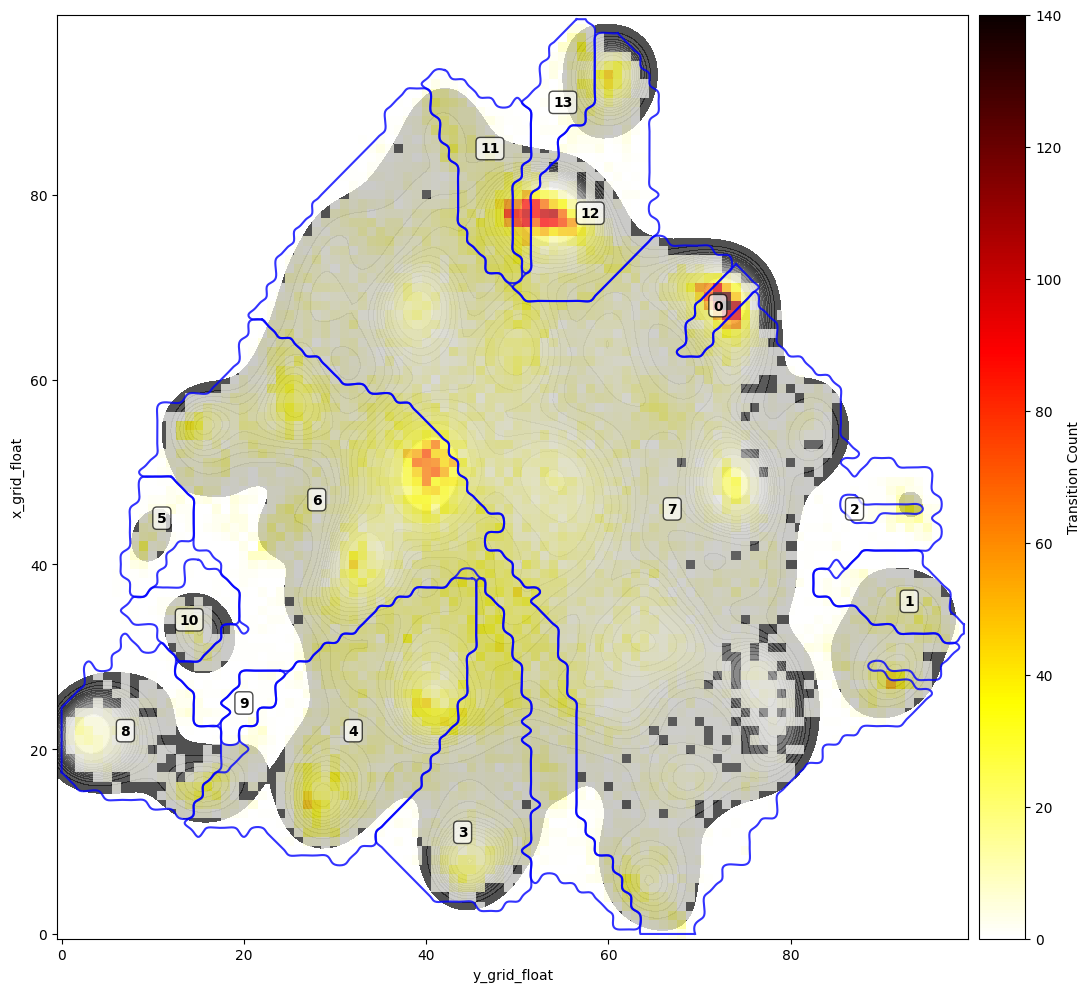

In [460]:
plot_enhanced_basin_map(enriched_df,analyzer,boundary_smoothing=0)
plt.show()

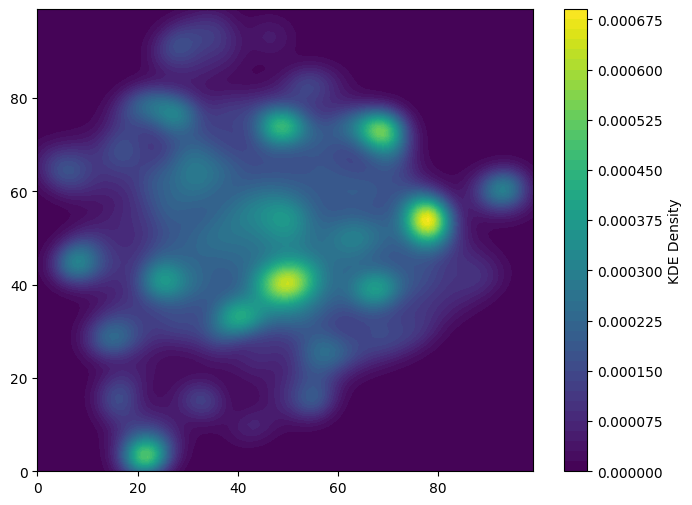

In [524]:
import matplotlib.pyplot as plt
from  scipy.stats import gaussian_kde

df = enriched_df

fig, ax = plt.subplots(figsize=(8, 6))
x_data = df['x_grid_float'].values
y_data = df['y_grid_float'].values
data = np.vstack([x_data, y_data])

# Compute the KDE using a Gaussian kernel
kde = gaussian_kde(data)

# Define the grid over the raw data range
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the KDE on the grid and reshape
kde_values = kde(grid_coords).reshape(xx.shape)

# Create a filled contour plot of the KDE density
contour = ax.contourf(xx, yy,kde_values, levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label='KDE Density')
plt.show()

/tmp/ipykernel_1644527/2213742163.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


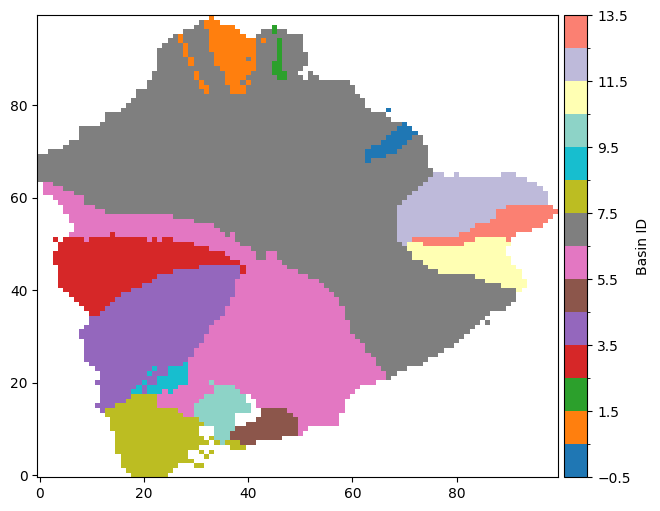

In [527]:
basin_grid = analyzer.basin_grid

fig, ax = plt.subplots(figsize=(8,6))

# Get grid dimensions
nx, ny = basin_grid.shape

# Create a mask for areas with no basin
no_basin_mask = (basin_grid == -1)

# Create a copy of the basin grid for visualization
vis_grid = basin_grid.copy()

# Count unique basins (excluding -1)
unique_basins = np.unique(vis_grid[vis_grid >= 0])
n_basins = len(unique_basins)

# Create coordinate grids - these ensure the proper orientation
x_coords = np.arange(0, nx)
y_coords = np.arange(0, ny)
X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')

if n_basins > 0:
    basin_cmap = combined_cmap(n_basins)
    
    # Create a normalized colormap
    norm = mcolors.BoundaryNorm(np.arange(-0.5, n_basins + 0.5), basin_cmap.N)
    
    # Replace -1 with masked value for visualization
    vis_grid = np.ma.masked_where(no_basin_mask, vis_grid)
    
    # Plot the basin heatmap
    basin_plot = ax.pcolormesh(X, Y, vis_grid, cmap=basin_cmap, norm=norm, shading='auto')
    
    # Add a colorbar for basins
    cbar_basins = plt.colorbar(basin_plot, ax=ax, location='right', pad=0.01)
    cbar_basins.set_label('Basin ID')

plt.show()

In [636]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from skimage.morphology import skeletonize
from skimage.measure import find_contours
from scipy.interpolate import splprep, splev

def extract_boundary_mask(basin_grid):
    """
    Create a binary mask of boundary cells.
    A cell is marked True if any of its 4-connected neighbors have a different label.
    The basin_grid can include -1 for missing data.
    """
    nrows, ncols = basin_grid.shape
    # Pad the array with a unique value (here -2) to avoid wrap-around.
    padded = np.pad(basin_grid, pad_width=1, mode='constant', constant_values=-2)
    boundary_mask = np.zeros_like(basin_grid, dtype=bool)
    # Check 4-connected neighbors.
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        shifted = padded[1+dx:1+dx+nrows, 1+dy:1+dy+ncols]
        # Removed (shifted != -2) to let edges be marked as boundaries.
        boundary_mask |= (basin_grid != shifted) & (basin_grid > -1)
    return boundary_mask

def adjust_basin_boundaries(basin_grid, df, step_size=0.1, move_threshold=0.01, max_iter=100, debug=True):
    """
    Adjust basin boundaries by:
      1. Extracting a boundary mask (cells adjacent to a different label)
      2. Skeletonizing the mask to get a centerline for wide boundaries.
      3. Extracting continuous curves from the skeleton.
      4. Iteratively nudging each curve's points according to the underlying KDE gradient.
    
    Parameters:
      basin_grid: 2D numpy array with basin IDs (cells with -1 are no-data).
      df: pandas DataFrame with columns 'x_grid_float' and 'y_grid_float'
          in the same coordinate system as basin_grid.
      step_size: multiplier for how far to nudge points in each iteration.
      move_threshold: minimum displacement threshold for convergence.
      max_iter: maximum number of iterations.
      debug: if True, prints iteration and displacement info.
      
    Returns:
      A list of updated boundary curves (each curve is an (N,2) numpy array of [x, y] points).
    """
    # ---------------------------
    # Step 1. Compute KDE and its gradient on a grid matching basin_grid
    # ---------------------------
    x_data = df['x_grid_float'].values
    y_data = df['y_grid_float'].values
    data = np.vstack([x_data, y_data])
    kde = gaussian_kde(data)
    
    nrows, ncols = basin_grid.shape
    # Create grid that spans the basin grid indices.
    x_grid = np.linspace(0, nrows-1, nrows)
    y_grid = np.linspace(0, ncols-1, ncols)
    xx, yy = np.meshgrid(x_grid, y_grid, indexing='ij')
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])
    
    kde_values = kde(grid_coords).reshape(xx.shape)
    # Smooth the KDE to reduce noise.
    kde_values = gaussian_filter(kde_values, sigma=1)
    
    # Compute gradients. With 'ij' indexing, axis 0 is x and axis 1 is y.
    grad = np.gradient(kde_values, axis=(0,1))
    grad_x = grad[0]
    grad_y = grad[1]
    
    def interpolate_gradient(pt):
        """
        Bilinearly interpolate the KDE gradient at a continuous point pt = (x, y).
        """
        x, y = pt
        i = int(np.floor(x))
        j = int(np.floor(y))
        i1 = min(i + 1, nrows - 1)
        j1 = min(j + 1, ncols - 1)
        dx = x - i
        dy = y - j
        g_x = (grad_x[i, j]*(1-dx)*(1-dy) +
               grad_x[i1, j]*(dx)*(1-dy) +
               grad_x[i, j1]*(1-dx)*(dy) +
               grad_x[i1, j1]*(dx)*(dy))
        g_y = (grad_y[i, j]*(1-dx)*(1-dy) +
               grad_y[i1, j]*(dx)*(1-dy) +
               grad_y[i, j1]*(1-dx)*(dy) +
               grad_y[i1, j1]*(dx)*(dy))
        return np.array([g_x, g_y])
    
    # ---------------------------
    # Step 2. Extract and skeletonize the boundary mask
    # ---------------------------
    boundary_mask = extract_boundary_mask(basin_grid)
    # Skeletonize to reduce wide boundaries to a centerline.
    skeleton = skeletonize(boundary_mask)
    
    if debug:
        n_boundary_pixels = np.sum(boundary_mask)
        n_skel_pixels = np.sum(skeleton)
        print(f"Boundary mask has {n_boundary_pixels} pixels; skeletonized to {n_skel_pixels} pixels.")
    
    # ---------------------------
    # Step 3. Extract continuous curves from the skeleton
    # ---------------------------
    # Use find_contours on the skeleton image (it should be nearly one-pixel wide)
    raw_curves = find_contours(skeleton.astype(float), level=0.5)
    
    # Spline-smooth the curves (if there are enough points)
    smoothed_curves = []
    for curve in raw_curves:
        # Note: find_contours returns curves as (N,2) with coordinates (row, col).
        if len(curve) < 3:
            continue
        try:
            tck, u = splprep(curve.T, s=2)
            new_points = np.array(splev(u, tck)).T
            smoothed_curves.append(new_points)
        except Exception as e:
            if debug:
                print("Spline smoothing failed for a curve, using original points.")
            smoothed_curves.append(curve)
    
    if debug:
        print(f"Extracted {len(smoothed_curves)} continuous boundary curves from the skeleton.")
    
    # ---------------------------
    # Step 4. Iteratively adjust boundary points using the KDE gradient.
    # ---------------------------
    iteration = 0
    max_disp = float('inf')
    while iteration < max_iter and max_disp > move_threshold:
        max_disp = 0
        new_curves = []
        for curve in smoothed_curves:
            new_curve = curve.copy()
            for idx in range(len(curve)):
                pt = curve[idx]
                # Estimate local tangent using neighbors (with periodic wrapping).
                prev_pt = curve[idx - 1]
                next_pt = curve[(idx + 1) % len(curve)]
                tangent = next_pt - prev_pt
                norm_tangent = np.linalg.norm(tangent)
                if norm_tangent == 0:
                    continue
                tangent /= norm_tangent
                # Compute normal (rotate tangent 90 degrees).
                normal = np.array([-tangent[1], tangent[0]])
                # Get the KDE gradient at the point.
                grad_val = interpolate_gradient(pt)
                # We wish to move the point in the direction of the negative gradient,
                # but only its component along the normal.
                proj = np.dot(-grad_val, normal)
                displacement = step_size * proj
                new_pt = pt + displacement * normal
                new_curve[idx] = new_pt
                max_disp = max(max_disp, np.abs(displacement))
            # Optional: smooth the updated curve with a moving average.
            smoothed_new_curve = np.array([
                (new_curve[(i-1)%len(new_curve)] + new_curve[i] + new_curve[(i+1)%len(new_curve)])/3.0 
                for i in range(len(new_curve))
            ])
            new_curves.append(smoothed_new_curve)
        smoothed_curves = new_curves
        iteration += 1
        if debug:
            print(f"Iteration {iteration}: max displacement = {max_disp:.5f}")
    
    return smoothed_curves



In [557]:
def majority_vote(values,special_value = -1):
    values = values.flatten()
    values = values[~np.isnan(values)]  # Remove NaN values
    if len(values) == 0:
        return np.nan
    
    # Count occurrences of each class (excluding special values)
    valid_values = values[values != special_value]
    if len(valid_values) == 0:
        return special_value
        
    unique_values, counts = np.unique(valid_values.astype(int), return_counts=True)
    if len(unique_values) == 0:
        return special_value
    return unique_values[np.argmax(counts)]

def convolve(data,kernel_size=3,special_value=-1):
    grid_copy = data.copy()
    grid_copy = ndimage.generic_filter(
        grid_copy,
        majority_vote,
        size=kernel_size,
        mode='nearest'
    )
    return grid_copy

#convolve(basin_grid)


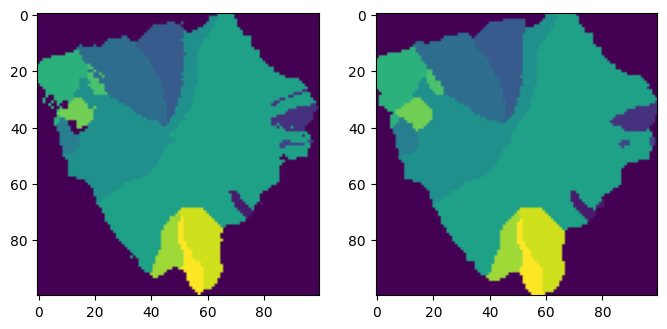

In [558]:
fig, ax = plt.subplots(1,2,figsize=(8, 6))
ax[0].imshow(basin_grid)
fixed = convolve(basin_grid)
ax[1].imshow(fixed)
plt.show()

In [1]:
# boundary_mask = extract_boundary_mask(fixed)
# # Skeletonize to reduce wide boundaries to a centerline.
# skeleton = skeletonize(boundary_mask)

import pickle
with open("./local_data/skeleton.pickle","rb") as f:
    skeleton = pickle.load(f)

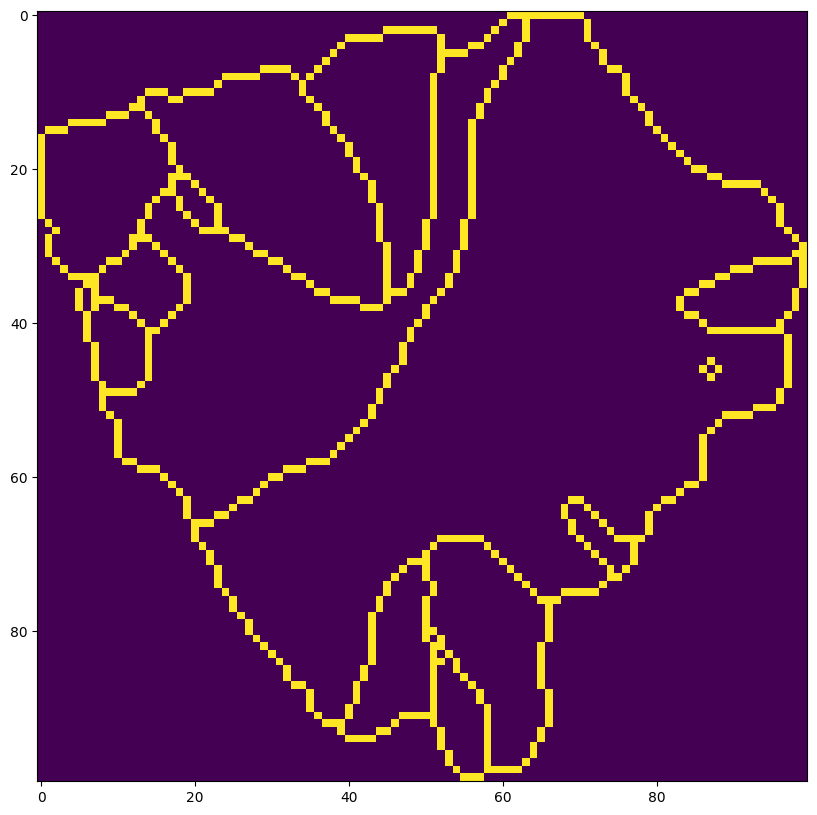

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(skeleton)
plt.show()

In [574]:
np.argwhere(skeleton)

array([[ 1, 46],
       [ 1, 47],
       [ 1, 48],
       ...,
       [98, 61],
       [98, 62],
       [99, 55]])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns




def improved_cmap(grid, background_value=0):
    """
    Create a colormap with distinct colors for each unique value in the grid,
    with a reserved gray color for the background.
    
    Parameters:
    grid: numpy array with integer values representing chain IDs
    background_value: value that represents the background (default 0)
    
    Returns:
    cmap: matplotlib colormap
    norm: matplotlib normalization to map values to colors
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    from matplotlib.colors import ListedColormap
    
    # Get unique values excluding the background
    unique_values = np.unique(grid)
    unique_values = unique_values[unique_values != background_value]
    n_values = len(unique_values)
    
    # Combine qualitative colormaps to get distinct colors
    cmaps = ['tab10', 'Set3', 'Dark2', 'Paired', 'Set1', 'Set2']
    colors = []
    
    for cmap_name in cmaps:
        cmap = plt.cm.get_cmap(cmap_name)
        colors.extend([cmap(i) for i in range(cmap.N)])
    
    # Remove colors that are too similar to the background (light grays)
    colors = [c for c in colors if not (0.7 < c[0] < 0.95 and 0.7 < c[1] < 0.95 and 0.7 < c[2] < 0.95)]
    
    # Add gray background color for index 0
    background_color = (0.85, 0.85, 0.85, 1.0)  # Light gray
    all_colors = [background_color]  # Start with background color
    
    # Make sure we have enough colors
    if len(colors) < n_values:
        # Generate more random distinct colors if needed
        additional_colors = [(np.random.random(), np.random.random(), np.random.random(), 1.0) 
                            for _ in range(n_values - len(colors))]
        colors.extend(additional_colors)
    
    # Add non-background colors
    all_colors.extend(colors)
    
    # Create colormap
    cmap = ListedColormap(all_colors)
    
    # Create a normalization that maps values correctly
    # For imshow with integer values, use boundaries between the integers
    boundaries = np.arange(-0.5, n_values + 1.5)  # +1 for background
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    
    # Function to apply to your grid for direct RGB output if needed
    def apply_colormap(grid_data):
        # First remap values to sequential integers, with background as 0
        remapped = np.zeros_like(grid_data)
        value_to_index = {background_value: 0}  # Background maps to 0
        
        current_index = 1
        for val in unique_values:
            value_to_index[val] = current_index
            current_index += 1
        
        for i in range(grid_data.shape[0]):
            for j in range(grid_data.shape[1]):
                val = grid_data[i, j]
                if val in value_to_index:
                    remapped[i, j] = value_to_index[val]
                else:
                    remapped[i, j] = 0  # Default to background
        
        return remapped
    
    return cmap, norm, apply_colormap


def plot_grid(grid):
    n_segs = len(np.unique(grid))

    cmap, norm, _ = improved_cmap(n_segs)

    # Create a normalized colormap
    norm = mcolors.BoundaryNorm(np.arange(-0.5, n_segs + 0.5), cmap.N)
    plt.figure(figsize=(12,10))

    im=plt.imshow(grid,cmap=cmap, norm=norm)
    plt.colorbar(im)
    plt.show()

In [104]:
import numpy as np
import networkx as nx
from skimage.measure import label

def skeleton_to_graph_incremental(component_mask, debug=False):
    """
    Convert a skeleton into a simplified graph while preserving junction structure,
    small loops, and small intrusions on the edges.
    """
    # ------- PHASE 1: Initial construction with pixel-level graph ------- #
    pixels = np.argwhere(component_mask)
    pixel_set = {tuple(p) for p in pixels}
    
    # Build initial graph with all pixels
    G = nx.Graph()
    for p in pixel_set:
        G.add_node(p,adjacencies = set())
    
    # Connect adjacent pixels
    for p in pixel_set:
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                neighbor = (p[0] + dx, p[1] + dy)
                if neighbor in pixel_set:
                    G.add_edge(p, neighbor, points=[p, neighbor])
    
    # ------- PHASE 2: Identify different node types ------- #
    junction_nodes = set()
    endpoint_nodes = set()
    chain_nodes = set()
    
    for node in G.nodes():
        degree = G.degree(node)
        if degree > 2:
            junction_nodes.add(node)
        elif degree == 1:
            endpoint_nodes.add(node)
        elif degree == 2:
            chain_nodes.add(node)
    

     # ------- PHASE 3: Collapse junctions ------- #
        # Label connected junction components
    junction_mask = np.zeros(component_mask.shape, dtype=bool)
    for j in junction_nodes:
        if j[0] < junction_mask.shape[0] and j[1] < junction_mask.shape[1]:
            junction_mask[j[0], j[1]] = True
    
    # Label connected junction components
    labeled_junctions = label(junction_mask, connectivity=2)
    
    # Create a mapping from junction pixel to cluster ID and representative
    cluster_to_pixels = {}
    
    # For each cluster, find a representative (using the centroid)
    for cluster_id in range(1, labeled_junctions.max() + 1):
        # Get all pixels in this cluster
        cluster_pixels = [p for p in junction_nodes if 
                            labeled_junctions[p[0], p[1]] == cluster_id]
        
        if not cluster_pixels:
            continue

        cluster_to_pixels[cluster_id] = cluster_pixels
            
        # Compute centroid
        centroid = np.mean(cluster_pixels, axis=0)
        
        # Find the junction pixel closest to the centroid
        closest_pixel = min(cluster_pixels, 
                           key=lambda p: ((p[0]-centroid[0])**2 + (p[1]-centroid[1])**2))
        
        #Collapse cluster to a single node
        neighbors = set()
        for p in cluster_pixels:
            for n in G.neighbors(p): 
                if n in chain_nodes:
                    neighbors.add(n)
        
        G.remove_nodes_from(cluster_pixels)
        for n in neighbors:
            G.add_edge(closest_pixel,n)
        
        junction_nodes.difference_update(cluster_pixels)
        junction_nodes.add(closest_pixel)
    if debug:
        return G,junction_nodes
    # --------- PHASE 4: Derive chains
    def derive_chain(n):
        chain = [n]
        # Traverse chain
        while True:
            nxt = [c for c in G.neighbors(chain[-1]) if c not in junction_nodes and c not in chain]
            if not nxt:
                break
            else:
                chain.append(nxt[0])
        
        return chain
    
    visited = set()
    chains = []

    for j in junction_nodes:
        neighbors = [n for n in G.neighbors(j)]
        for n in neighbors:
            chain = derive_chain(n)
            chain_desc = tuple(sorted([chain[0],chain[-1]]))
            if chain_desc in visited:
                continue
            else:
                visited.add(chain_desc)
            ends = [n for n in G.neighbors(chain[-1]) if n in junction_nodes and n != j]
            # Chain must be a loop
            if not ends:
                end = j                
            else:
                end = ends[0]
            
            chains.append([j]+chain+[end])

            
    return chains


In [ ]:
def validate_graph(G,junctions):
    print(f"{len(junctions)} junctions found")
    visited = set()
    for n in G.nodes():
        if n in visited:
            print(f"WARN: {n} appears more than once in graph")
            print(f"------------> junction node: {n in junctions}")
            print(f"------------> neighbors: {[j for j in G.neighbors(n)]}")
        visited.add(n)
        if n in junctions:
            print(f"{n} -> degree {G.degree(n)}")
            if any(j in junctions for j in G.neighbors(n)):
                print(f"WARN: {n} has junction neighbor")
        else:
            if G.degree(n) != 2:
                print(f"WARN: chain node {n} has degree {G.degree(n)}")
G,junctions = skeleton_to_graph_incremental(skeleton,debug=True)
validate_graph(G,junctions)

22 junctions found
(0, 63) -> degree 3
(5, 52) -> degree 3
(9, 34) -> degree 3
(12, 13) -> degree 3
(22, 17) -> degree 4
(28, 23) -> degree 3
(29, 13) -> degree 3
(31, 99) -> degree 3
(36, 7) -> degree 6
(36, 45) -> degree 3
(41, 96) -> degree 3
(41, 14) -> degree 3
(49, 8) -> degree 3
(66, 20) -> degree 3
(68, 77) -> degree 3
(71, 50) -> degree 3
(73, 74) -> degree 3
(76, 66) -> degree 3
(82, 51) -> degree 3
(91, 51) -> degree 3
(92, 39) -> degree 3
(98, 58) -> degree 3


4


/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_42793/3104343317.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


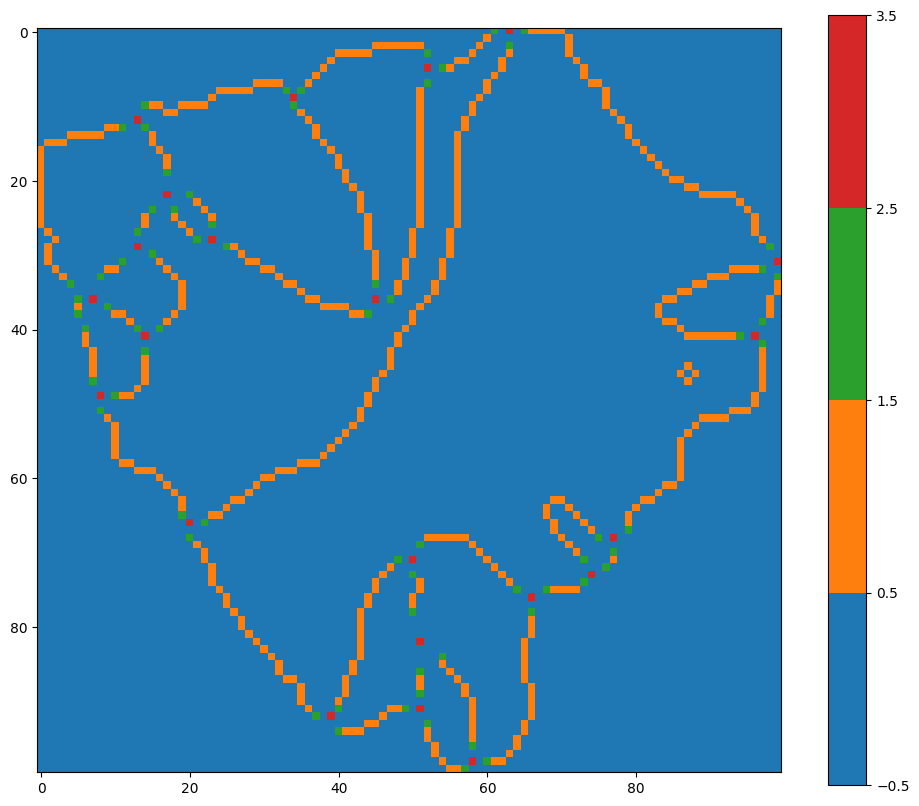

In [45]:
G,junctions = skeleton_to_graph_incremental(skeleton)
grid = np.zeros((100,100))
for n in G.nodes():
    if n in junctions:
        grid[n[0],n[1]] = 3
    else:
        if any(j in junctions for j in G.neighbors(n)):
            grid[n[0],n[1]] = 2
            if G.degree(n) != 2:
                print("What?")
                print(f"{n} has {G.degree(n)}")
        else:    
            grid[n[0],n[1]] = 1
plot_grid(grid)

In [105]:
chains = skeleton_to_graph_incremental(skeleton)
print(f"Retrieved {len(chains)} chains")

Retrieved 35 chains


/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_42793/2771772764.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


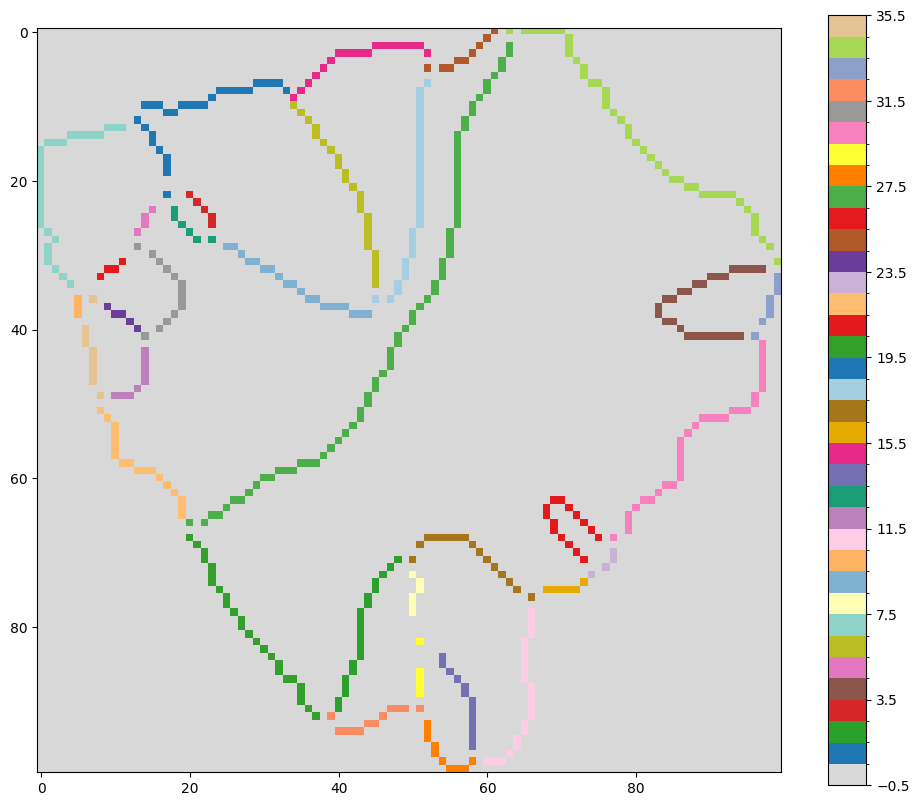

In [106]:
grid = np.zeros((100,100))
import random
random.shuffle(chains)
for i,c in enumerate(chains):
    for p in c:
        grid[p[0],p[1]] = i+1
plot_grid(grid)



In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def Bernstein(n, k):
    """Bernstein polynomial.

    """
    coeff = binom(n, k)

    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)

    return _bpoly


def Bezier(points, num=200):
    """Build Bézier curve from points.

    """
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
    return curve

smooth_chains = []
for i,c in enumerate(chains):
    print(f"Smooth chain of length {len(c)}")
    if len(c) >= 3:
        x,y = Bezier(c,100).T
        chain_smooth = np.vstack([x,y]).T
    else:
        chain_smooth = np.vstack(c)

    smooth_chains.append(chain_smooth)

Smooth chain of length 22
Smooth chain of length 23
Smooth chain of length 7
Smooth chain of length 29
Smooth chain of length 6
Smooth chain of length 27
Smooth chain of length 32
Smooth chain of length 8
Smooth chain of length 22
Smooth chain of length 5
Smooth chain of length 25
Smooth chain of length 11
Smooth chain of length 7
Smooth chain of length 15
Smooth chain of length 20
Smooth chain of length 8
Smooth chain of length 16
Smooth chain of length 32
Smooth chain of length 9
Smooth chain of length 28
Smooth chain of length 17
Smooth chain of length 20
Smooth chain of length 5
Smooth chain of length 7
Smooth chain of length 10
Smooth chain of length 6
Smooth chain of length 74
Smooth chain of length 11
Smooth chain of length 6
Smooth chain of length 35
Smooth chain of length 13
Smooth chain of length 12
Smooth chain of length 9
Smooth chain of length 44
Smooth chain of length 10


In [111]:
len(chain_smooth)

100

## Step 4: Boundary Adjustment

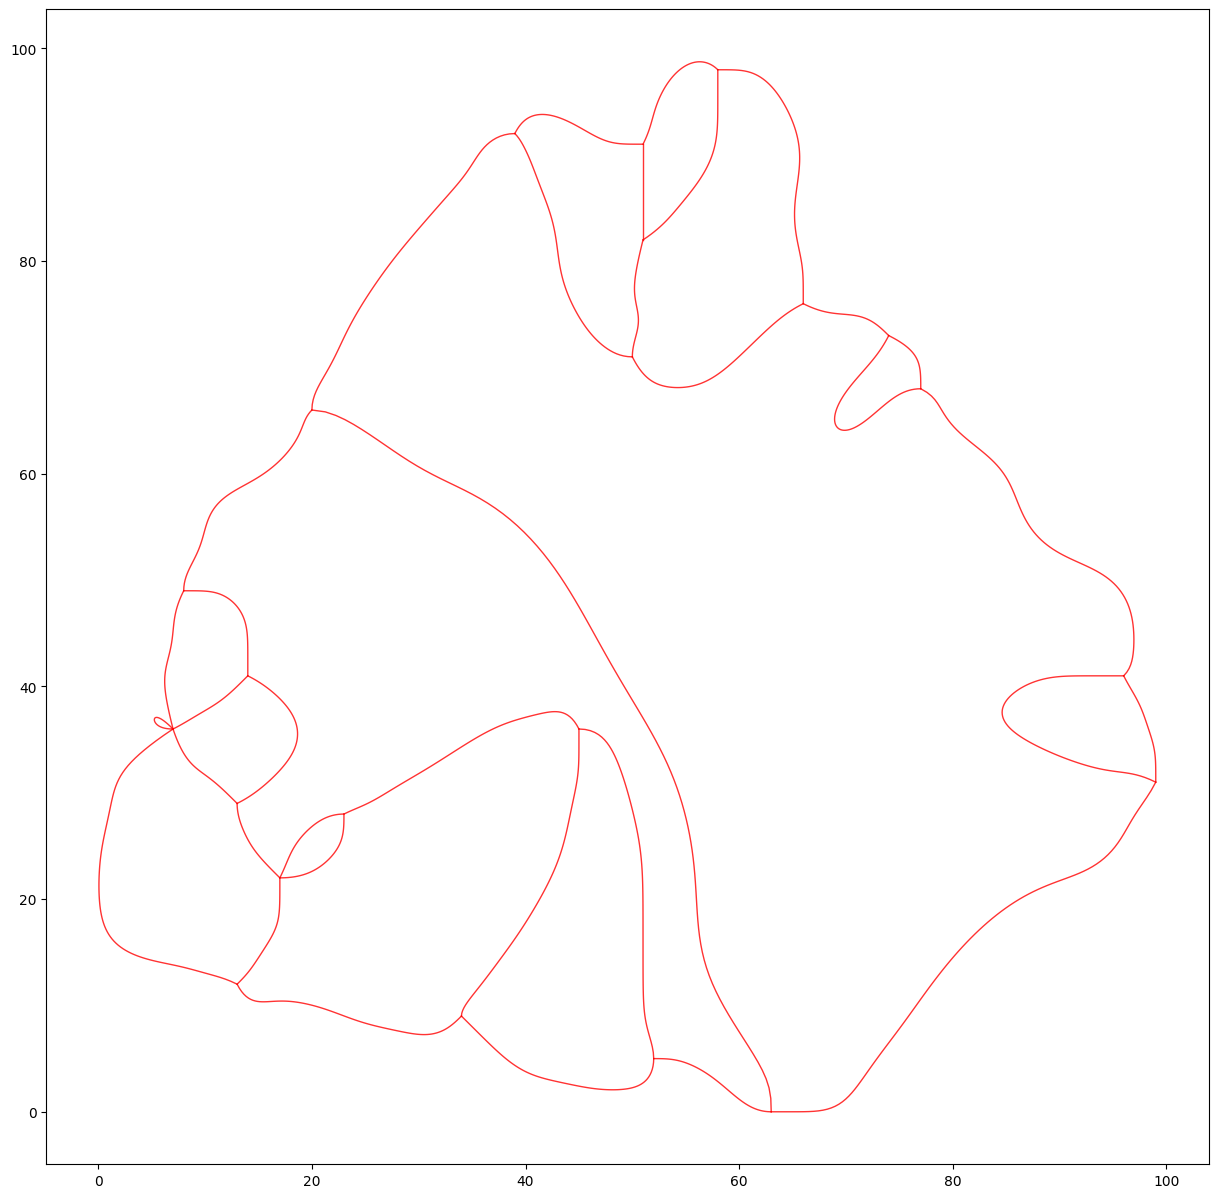

In [ ]:
fig,ax = plt.subplots(figsize=(15, 15))
for sc in smooth_chains:
    ax.plot(sc[:, 1],sc[:, 0], color="red", linewidth=1, alpha=0.8)
plt.show()

In [114]:
trace = pd.read_feather("./local_data/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather")
trace

x         y                        dt                 u_id  \
0       21.852156 -5.451804 2020-10-05 13:11:46+00:00                12428   
1       27.193310 -2.597215 2020-10-08 04:00:51+00:00                29283   
2       27.084763 -2.203044 2020-08-19 22:36:36+00:00                29283   
3       27.100113 -2.104184 2020-09-30 03:38:11+00:00                29283   
4       26.849157 -2.106781 2020-08-24 22:35:13+00:00                29283   
...           ...       ...                       ...                  ...   
166281  23.478403  0.925553 2020-10-26 18:04:09+00:00  1304368695687479297   
166282  26.105059 -4.188040 2020-09-29 17:08:22+00:00  1305305314875637761   
166283  25.819817 -3.943700 2020-10-01 16:28:29+00:00  1305305314875637761   
166284  25.748693 -3.820274 2020-10-05 22:29:09+00:00  1305305314875637761   
166285  26.012646 -3.758329 2020-10-23 14:19:49+00:00  1305305314875637761   

        clust_labels  botscore  
0                1.0      0.07  
1                1.0      0.22  
2                1.0      0.22  
3                1.0      0.22  
4                1.0      0.22  
...              ...       ...  
166281           1.0       NaN  
166282           1.0       NaN  
166283           1.0       NaN  
166284           1.0       NaN  
166285           1.0       NaN  

[166286 rows x 6 columns]

In [119]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator
from scipy.ndimage import distance_transform_edt, binary_erosion

def enrich_df(original_df, grid_dim=100, x_col='x', y_col='y'):
    """
    Enrich the original user data with insights from the vector field and basin analysis.
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        Original dataframe with user positions in real coordinates (not grid)
    x_col, y_col : str
        Column names for x and y coordinates in the original dataframe
    user_id_col : str
        Column name for user ID in the original dataframe
    time_col : str
        Column name for timestamp in the original dataframe
    trajectory_analyzer : TrajectoryAnalysis object, optional
        If provided, use the existing analyzer object for vector field operations
        
    Returns:
    --------
    pandas.DataFrame
        Enriched original dataframe with additional columns for basin membership,
        vector field properties, and user dynamics metrics
    """

   
    # Create a copy of the original dataframe
    df_enriched = original_df.copy()
    
    # Get min/max of original coordinates for scaling
    x_orig_min, x_orig_max = df_enriched[x_col].min(), df_enriched[x_col].max()
    y_orig_min, y_orig_max = df_enriched[y_col].min(), df_enriched[y_col].max()
    
    
    # Map original coordinates to grid coordinates for interpolation
    x_norm = (df_enriched[x_col] - x_orig_min) / (x_orig_max - x_orig_min)
    y_norm = (df_enriched[y_col] - y_orig_min) / (y_orig_max - y_orig_min)
    df_enriched['x_grid_float'] = x_norm * (grid_dim - 1)
    df_enriched['y_grid_float'] = y_norm * (grid_dim - 1)
    df_enriched['x_grid'] = df_enriched['x_grid_float'].astype(int).clip(0, grid_dim-1)
    df_enriched['y_grid'] = df_enriched['y_grid_float'].astype(int).clip(0, grid_dim-1)
    return df_enriched

In [141]:
enriched_df['x_grid'].min()

0

In [123]:
enriched_df = enrich_df(trace)

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

def adjust_basin_boundaries(smoothed_curves, df, kde_values= None, step_size=.2, move_threshold=1e-7, local_grad_threshold = .1, max_iter=100, debug=True,normalize_grad=False):
    """
    Adjusts boundary curves (splines) so that they are nudged toward the valleys of an underlying KDE.
    
    Parameters:
      smoothed_curves : list of (N,2) numpy arrays representing each spline.
      df              : DataFrame containing KDE grid data (with keys 'x_grid_float', 'y_grid_float',
                        'x_grid', and 'y_grid').
      step_size       : Scaling factor for the displacement.
      move_threshold  : Minimum displacement threshold to stop iterations.
      max_iter        : Maximum number of iterations.
      debug           : If True, prints iteration status.
    
    Returns:
      A tuple (updated_curves, kde_values) where updated_curves is a list of (N,2) arrays,
      and kde_values is the computed (smoothed) KDE grid.
    """
    print(f"NORMALIZE {normalize_grad}")
    # ---------------------------
    # Step 1. Compute KDE and its gradient on a grid matching basin_grid
    # ---------------------------
    x_data = df['x_grid_float'].values
    y_data = df['y_grid_float'].values
    data = np.vstack([x_data, y_data])

    
    # Infer grid shape.
    nrows = 1 + df["x_grid"].max() - df["x_grid"].min()
    ncols = 1 + df["y_grid"].max() - df["y_grid"].min()
    
    x_grid = np.linspace(0, nrows-1, nrows)
    y_grid = np.linspace(0, ncols-1, ncols)
    xx, yy = np.meshgrid(x_grid, y_grid, indexing='ij')
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])
    
    if kde_values is None:
        print("Generating KDE")
        kde = gaussian_kde(data)
        kde_values = kde(grid_coords).reshape(xx.shape)
        # Smooth the KDE to reduce noise.
        kde_values = gaussian_filter(kde_values, sigma=1)
        print("Done KDE analysis")

    min_z, max_z = kde_values.min(), kde_values.max()
    #placeholder
    threshold_z = min_z+(max_z-min_z) * .05
       
    # Compute gradients (axis 0 is x, axis 1 is y).
    grad = np.gradient(kde_values, axis=(0,1))
    grad_x = grad[0]
    grad_y = grad[1]
    
    def interpolate_gradient(pt, normalize=False):
        """
        Bilinearly interpolate the KDE gradient at a continuous point pt = (x, y).
        The point is clipped to the grid so that indices remain valid.
        If normalize is True, returns the gradient as a unit vector.
        """
        x, y = pt
        # Clip to ensure we are safely within bounds.
        x = np.clip(x, 0, nrows - 1 - 1e-6)
        y = np.clip(y, 0, ncols - 1 - 1e-6)
        i = int(np.floor(x))
        j = int(np.floor(y))

        #We're going to just stop if we're really low on the surface
        if kde_values[i,j] <=threshold_z:
            return np.array([0,0])

        i1 = min(i + 1, nrows - 1)
        j1 = min(j + 1, ncols - 1)
        dx = x - i
        dy = y - j
        g_x = (grad_x[i, j]*(1-dx)*(1-dy) +
               grad_x[i1, j]*(dx)*(1-dy) +
               grad_x[i, j1]*(1-dx)*(dy) +
               grad_x[i1, j1]*(dx)*(dy))
        g_y = (grad_y[i, j]*(1-dx)*(1-dy) +
               grad_y[i1, j]*(dx)*(1-dy) +
               grad_y[i, j1]*(1-dx)*(dy) +
               grad_y[i1, j1]*(dx)*(dy))
        grad_vec = np.array([g_x, g_y])
        if normalize:
            norm = np.linalg.norm(grad_vec)
            if norm > 0:
                grad_vec = grad_vec / norm
        
        return grad_vec
    # ---------------------------
    # Step 2. Identify shared endpoints.
    # ---------------------------
    # For each curve, consider its first and last points.
    # Group endpoints that are within a small tolerance (i.e. "shared" nodes).
    shared_groups = []
    for i, curve in enumerate(smoothed_curves):
        for j in [0, len(curve)-1]:
            pt = curve[j]
            found = False
            for group in shared_groups:
                rep_curve_idx, rep_pt_idx = group[0]
                rep_pt = smoothed_curves[rep_curve_idx][rep_pt_idx]
                if np.allclose(pt, rep_pt, atol=1e-5):
                    group.append((i, j))
                    found = True
                    break
            if not found:
                shared_groups.append([(i, j)])
    # Retain only groups that have more than one endpoint (i.e. truly shared).
    shared_groups = [group for group in shared_groups if len(group) > 1]
    
    # ---------------------------
    # Step 3. Iteratively adjust boundary points using the KDE gradient.
    # ---------------------------
    iteration = 0
    max_disp = float('inf')
   
    
    while iteration < max_iter and max_disp > move_threshold:
        max_disp = 0
        max_grad = 0
        # Make a copy of curves for this iteration.
        new_curves = [curve.copy() for curve in smoothed_curves]
        # Dictionary to accumulate displacement vectors for shared endpoints.
        shared_disp = {g: [] for g in range(len(shared_groups))}
        
        # Process each curve point by point.
        total_points = 0
        total_moved = 0
        for curve_idx, curve in enumerate(smoothed_curves):
            new_curve = new_curves[curve_idx]
            num_points = len(curve)
            total_points += num_points
            for idx in range(num_points):
                pt = curve[idx]
                # Check if the point is an endpoint.
                if idx == 0 or idx == num_points - 1:
                    # Determine whether this endpoint belongs to a shared group.
                    is_shared = False
                    shared_group_index = None
                    for g, group in enumerate(shared_groups):
                        if (curve_idx, idx) in group:
                            is_shared = True
                            shared_group_index = g
                            break
                    # Use one-sided difference for endpoints.
                    if idx == 0:
                        tangent = curve[1] - curve[0]
                    else:
                        tangent = curve[-1] - curve[-2]

                    norm_tangent = np.linalg.norm(tangent)
                    if norm_tangent == 0:
                        continue
                    tangent /= norm_tangent
                    normal = np.array([-tangent[1], tangent[0]])
                    grad_val = interpolate_gradient(pt,normalize=normalize_grad)
                    proj = np.dot(-grad_val, normal)

                    #TODO: Do something smarter here
                    if np.linalg.norm(proj) < local_grad_threshold:
                        proj = 0
                    else:
                        total_moved+=1

                    max_grad = max(np.linalg.norm(proj),max_grad)
                    displacement = step_size * proj
                    
                    disp_vector = displacement * normal
                    if is_shared:
                        # For shared endpoints, accumulate the displacement.
                        shared_disp[shared_group_index].append(disp_vector)
                    else:
                        new_pt = pt + disp_vector
                        # Clip the new point to remain within the grid.
                        new_pt = np.clip(new_pt, [0, 0], [nrows - 1, ncols - 1])
                        new_curve[idx] = new_pt
                        max_disp = max(max_disp, np.abs(displacement))
                else:
                    # Internal point: use central difference.
                    prev_pt = curve[idx - 1]
                    next_pt = curve[idx + 1]
                    tangent = next_pt - prev_pt
                    norm_tangent = np.linalg.norm(tangent)
                    if norm_tangent == 0:
                        continue
                    tangent /= norm_tangent
                    normal = np.array([-tangent[1], tangent[0]])
                    grad_val = interpolate_gradient(pt,normalize=normalize_grad)
                   
                    proj = np.dot(-grad_val, normal)

                    #TODO: Do something smarter here
                    if np.linalg.norm(proj) < local_grad_threshold:
                        proj = 0
                    else:
                        total_moved+=1
                        
                    max_grad = max(np.linalg.norm(proj),max_grad)
                    displacement = step_size * proj
                    new_pt = pt + displacement * normal
                    new_pt = np.clip(new_pt, [0, 0], [nrows - 1, ncols - 1])
                    new_curve[idx] = new_pt
                    max_disp = max(max_disp, np.abs(displacement))
        
        # Update shared endpoints with the average displacement from all connected curves.
        for g, disp_list in shared_disp.items():
            if len(disp_list) > 0:
                avg_disp = np.mean(disp_list, axis=0)
                disp_magnitude = np.linalg.norm(avg_disp)
                max_disp = max(max_disp, disp_magnitude)
                # Update each endpoint in the shared group.
                for (curve_idx, endpoint_idx) in shared_groups[g]:
                    new_pt = smoothed_curves[curve_idx][endpoint_idx] + avg_disp
                    new_pt = np.clip(new_pt, [0, 0], [nrows - 1, ncols - 1])
                    new_curves[curve_idx][endpoint_idx] = new_pt
        
        # ---------------------------
        # Step 4. Smooth the updated curves (without wrapping endpoints).
        # ---------------------------
        smoothed_new_curves = []
        for curve in new_curves:
            num_points = len(curve)
            smoothed_curve = curve.copy()
            for i in range(num_points):
                # Leave endpoints unchanged.
                if i == 0 or i == num_points - 1:
                    continue
                else:
                    smoothed_curve[i] = (curve[i-1] + curve[i] + curve[i+1]) / 3.0
            smoothed_new_curves.append(smoothed_curve)
        
        smoothed_curves = smoothed_new_curves
        iteration += 1
        if debug:
            print(f"Iteration {iteration}: max displacement = {max_disp:.5f} max gradient = {max_grad:.7f} total_updates = {(total_moved / total_points):.3f}")
    
    return smoothed_curves, kde_values


In [214]:
np.linalg.norm([1,-1])

1.4142135623730951

In [259]:
final_curves,kde_result = adjust_basin_boundaries(smooth_chains,enriched_df, kde_values=kde_result, step_size=.1, max_iter=50,local_grad_threshold=.5,normalize_grad=True)

NORMALIZE True
Iteration 1: max displacement = 0.10000 max gradient = 0.9999999 total_updates = 0.458
Iteration 2: max displacement = 0.10000 max gradient = 0.9999998 total_updates = 0.450
Iteration 3: max displacement = 0.10000 max gradient = 0.9999997 total_updates = 0.441
Iteration 4: max displacement = 0.10000 max gradient = 1.0000000 total_updates = 0.433
Iteration 5: max displacement = 0.10000 max gradient = 0.9999999 total_updates = 0.426
Iteration 6: max displacement = 0.10000 max gradient = 0.9999997 total_updates = 0.419
Iteration 7: max displacement = 0.10000 max gradient = 1.0000000 total_updates = 0.410
Iteration 8: max displacement = 0.10000 max gradient = 1.0000000 total_updates = 0.405
Iteration 9: max displacement = 0.10000 max gradient = 0.9999994 total_updates = 0.402
Iteration 10: max displacement = 0.10000 max gradient = 0.9999974 total_updates = 0.391
Iteration 11: max displacement = 0.10000 max gradient = 1.0000000 total_updates = 0.385
Iteration 12: max displace

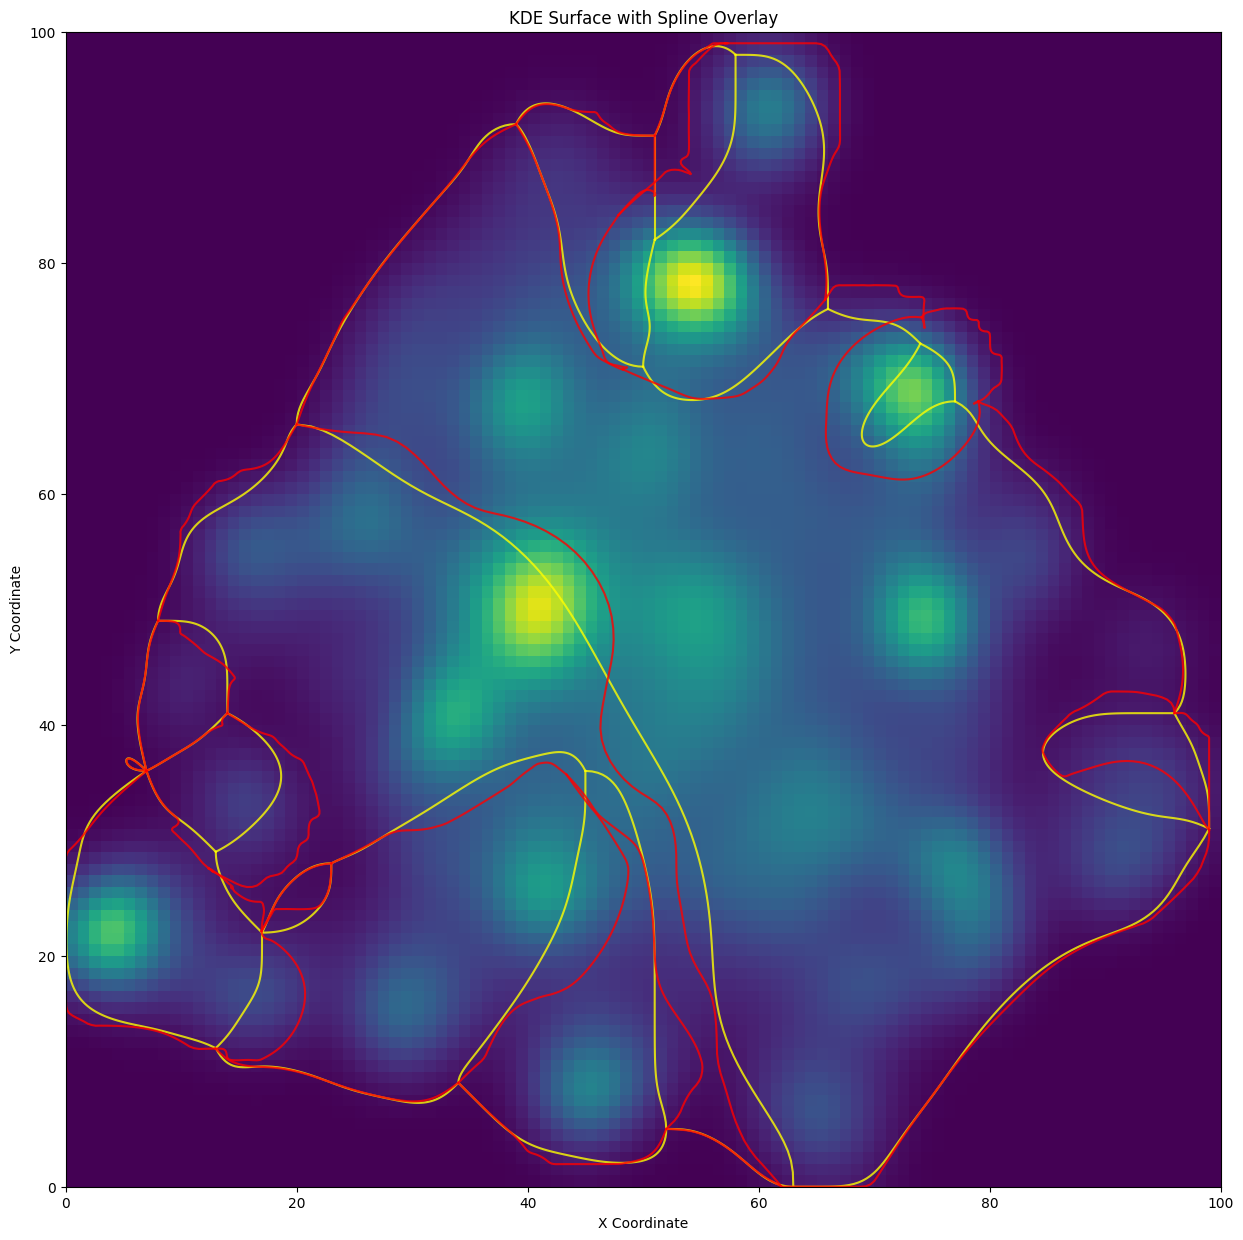

In [260]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Display the KDE image with correct orientation
# The 'origin' parameter controls the y-axis orientation
# Set 'extent' to define the coordinate space
ax.imshow(kde_result, origin='lower', extent=[0, 100, 0, 100], cmap='viridis')

# Overlay splines on the same axis
for sc in smooth_chains:
    ax.plot(sc[:, 1], sc[:, 0], color="yellow", linewidth=1.5, alpha=0.8)

# Overlay splines on the same axis
for sc in final_curves:
    ax.plot(sc[:, 1], sc[:, 0], color="red", linewidth=1.5, alpha=0.8)

# Optional: Add labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('KDE Surface with Spline Overlay')

plt.show()

In [540]:
updated_boundaries = adjust_basin_boundaries(basin_grid, enriched_df,
                                                 step_size=0.1,
                                                 move_threshold=0.000001,
                                                 max_iter=50,
                                                 debug=True)

Boundary mask has 1842 pixels; skeletonized to 1051 pixels.
Extracted 242 continuous boundary curves from the skeleton.
Iteration 1: max displacement = 0.00001
Iteration 2: max displacement = 0.00001
Iteration 3: max displacement = 0.00001
Iteration 4: max displacement = 0.00001
Iteration 5: max displacement = 0.00001
Iteration 6: max displacement = 0.00001
Iteration 7: max displacement = 0.00001
Iteration 8: max displacement = 0.00001
Iteration 9: max displacement = 0.00001
Iteration 10: max displacement = 0.00001
Iteration 11: max displacement = 0.00001
Iteration 12: max displacement = 0.00001
Iteration 13: max displacement = 0.00001
Iteration 14: max displacement = 0.00001
Iteration 15: max displacement = 0.00001
Iteration 16: max displacement = 0.00001
Iteration 17: max displacement = 0.00001
Iteration 18: max displacement = 0.00001
Iteration 19: max displacement = 0.00001
Iteration 20: max displacement = 0.00001
Iteration 21: max displacement = 0.00001
Iteration 22: max displaceme

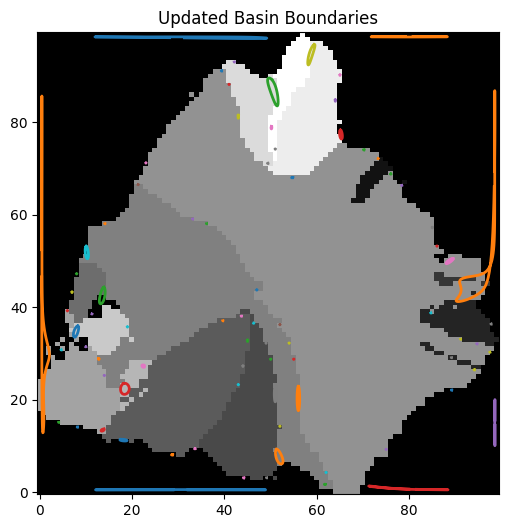

In [541]:


fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(basin_grid, cmap='gray', origin='lower')
for contour in updated_boundaries:
        ax.plot(contour[:,1], contour[:,0], linewidth=2)
ax.set_title("Updated Basin Boundaries")
plt.show()

In [517]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

import numpy as np
from scipy.interpolate import RegularGridInterpolator

# def compute_active_contour_boundaries(kde_values, xx, yy, markers,
#                                       init_radius=0.05, num_points=50,
#                                       step_size=0.1, max_iter=500,
#                                       change_threshold=1e-4, smoothing_weight=0.1):
#     """
#     Compute closed, active-contour boundaries from KDE data.
    
#     For each marker (provided as a 2D array with nonzero labels), a small circular
#     contour is initialized. Then, the contour is iteratively evolved: at each contour point,
#     the local tangent (from its neighboring points) is computed, the outward normal is determined 
#     (using the marker as a reference for what is “inside”), and the point is moved along the normal 
#     (in the direction that reduces the KDE value) by a fixed step. Optionally, a smoothing step is applied.
    
#     Parameters:
#     -----------
#     kde_values : 2D numpy.ndarray
#         Array of KDE density values defined on a grid.
#     xx, yy : 2D numpy.ndarray
#         Meshgrids of x and y coordinates corresponding to kde_values.
#     markers : 2D numpy.ndarray
#         An array (same shape as kde_values) with nonzero integer labels at marker locations.
#     init_radius : float, optional
#         Initial radius for the circular contour (in grid coordinate units).
#     num_points : int, optional
#         Number of points to sample on the initial contour.
#     step_size : float, optional
#         Step size for moving contour points in each iteration.
#     max_iter : int, optional
#         Maximum number of iterations for evolving each contour.
#     change_threshold : float, optional
#         Average movement threshold for stopping iteration.
#     smoothing_weight : float, optional
#         Weight for a simple smoothing term (averaging with neighbors) at each iteration.
        
#     Returns:
#     --------
#     boundaries : dict
#         Dictionary mapping marker labels (or an index) to the final contour.
#         Each contour is an array of shape (num_points, 2) representing (x, y) coordinates.
#     """
#     # Define grid coordinates (assumes xx and yy are produced by meshgrid)
#     grid_x = xx[0, :]
#     grid_y = yy[:, 0]
    
#     # Create an interpolator for the KDE so we can evaluate at arbitrary points.
#     kde_interp = RegularGridInterpolator((grid_y, grid_x), kde_values,
#                                          bounds_error=False, fill_value=None)
    
#     # Extract marker locations (where markers > 0) and associate each with its label.
#     marker_indices = np.argwhere(markers > 0)
#     boundaries = {}
#     marker_counter = 0  # used as a key if labels are not unique
    
#     for idx in marker_indices:
#         i, j = idx
#         # Use the grid to convert indices to coordinate values.
#         marker_pt = np.array([xx[i, j], yy[i, j]])
        
#         # Initialize a circular contour around the marker.
#         angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
#         contour = np.array([marker_pt + init_radius * np.array([np.cos(a), np.sin(a)]) 
#                             for a in angles])
        
#         # Evolve the contour.
#         for it in range(max_iter):
#             new_contour = np.empty_like(contour)
#             total_change = 0.0
#             for k in range(num_points):
#                 # Get the previous and next points (with periodic boundary conditions).
#                 prev_pt = contour[(k - 1) % num_points]
#                 next_pt = contour[(k + 1) % num_points]
#                 current_pt = contour[k]
                
#                 # Compute the local tangent (approximate derivative).
#                 tangent = next_pt - prev_pt
#                 norm_tan = np.linalg.norm(tangent)
#                 if norm_tan == 0:
#                     tangent_unit = np.array([0.0, 0.0])
#                 else:
#                     tangent_unit = tangent / norm_tan
                
#                 # Outward normal: rotate tangent by 90 degrees.
#                 # There are two choices: (-tangent_y, tangent_x) and its negative.
#                 candidate_normal = np.array([-tangent_unit[1], tangent_unit[0]])
#                 # Determine which direction is outward:
#                 # Compute the vector from marker to current point.
#                 vec_marker = current_pt - marker_pt
#                 # If dot(candidate_normal, vec_marker) is negative, flip normal.
#                 if np.dot(candidate_normal, vec_marker) < 0:
#                     candidate_normal = -candidate_normal
                
#                 # Evaluate the KDE at the current point.
#                 current_val = kde_interp([current_pt[1], current_pt[0]])
                
#                 # Propose two candidate moves: one outward and one inward.
#                 pt_out = current_pt + step_size * candidate_normal
#                 pt_in = current_pt - step_size * candidate_normal
#                 val_out = kde_interp([pt_out[1], pt_out[0]])
#                 val_in = kde_interp([pt_in[1], pt_in[0]])
                
#                 # Choose the candidate that gives a lower KDE value.
#                 # (We assume the density decreases as we move away from the peak.)
#                 if val_out is None or val_in is None:
#                     chosen_pt = current_pt
#                 else:
#                     if val_out < current_val or val_in < current_val:
#                         # Move in the direction that minimizes the KDE value.
#                         if val_out < val_in:
#                             chosen_pt = pt_out
#                         else:
#                             chosen_pt = pt_in
#                     else:
#                         chosen_pt = current_pt  # no improvement
                    
#                 new_contour[k] = chosen_pt
#                 total_change += np.linalg.norm(chosen_pt - current_pt)
            
#             # Optional smoothing: average each point with its neighbors.
#             smoothed_contour = new_contour.copy()
#             for k in range(num_points):
#                 prev_pt = new_contour[(k - 1) % num_points]
#                 next_pt = new_contour[(k + 1) % num_points]
#                 smoothed_contour[k] = ((1 - smoothing_weight) * new_contour[k] +
#                                        smoothing_weight * (prev_pt + next_pt) / 2)
            
#             new_contour = smoothed_contour
            
#             avg_change = total_change / num_points
#             contour = new_contour
#             if avg_change < change_threshold:
#                 break
        
#         boundaries[marker_counter] = contour
#         marker_counter += 1
    
#     return boundaries
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def compute_active_contour_boundaries(kde_values, xx, yy, markers,
                                                    init_radius=0.05, num_points=50,
                                                    step_size=0.1, max_iter=500,
                                                    change_threshold=1e-4, smoothing_weight=0.1):
    """
    Compute closed, active-contour boundaries (elastic bands) that evolve simultaneously,
    with collision detection between rings. The evolution stops if:
      - A point reaches the global minimum KDE value.
      - Its displacement is below the threshold (using max change over the ring).
      - It collides with a point from another ring.
    
    Parameters:
    -----------
    kde_values : 2D numpy.ndarray
        KDE density values defined on a grid.
    xx, yy : 2D numpy.ndarray
        Meshgrids of x and y coordinates corresponding to kde_values.
    markers : 2D numpy.ndarray
        Array (same shape as kde_values) with nonzero integer labels at marker locations.
    init_radius : float, optional
        Initial radius for the circular contour around each marker.
    num_points : int, optional
        Number of points used to discretize each contour.
    step_size : float, optional
        Step size for evolving contour points (in grid coordinate units).
    max_iter : int, optional
        Maximum number of iterations for contour evolution.
    change_threshold : float, optional
        Maximum displacement threshold below which evolution stops.
    smoothing_weight : float, optional
        Weight used for smoothing the contour at each iteration.
    
    Returns:
    --------
    contours : dict
        Dictionary mapping ring IDs to their final contour.
        Each contour is an array of shape (num_points, 2) of (x, y) coordinates.
    """
    # Grid info: assume xx and yy come from meshgrid over a uniform grid.
    grid_x = xx[0, :]  # x coordinates (length = grid_points)
    grid_y = yy[:, 0]  # y coordinates (length = grid_points)
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    
    # Compute global minimum KDE value (stop if reached).
    global_min = np.min(kde_values)
    
    # Create an interpolator for the KDE.
    kde_interp = RegularGridInterpolator((grid_y, grid_x), kde_values,
                                         bounds_error=False, fill_value=None)
    
    # Create interpolators for gradient (if needed later).
    grad_y, grad_x = np.gradient(kde_values, dy, dx)
    interp_grad_x = RegularGridInterpolator((grid_y, grid_x), grad_x,
                                              bounds_error=False, fill_value=0.0)
    interp_grad_y = RegularGridInterpolator((grid_y, grid_x), grad_y,
                                              bounds_error=False, fill_value=0.0)
    
    # Helper: Convert continuous point (x,y) to occupancy grid index (row, col).
    def pos_to_idx(pt):
        # pt is (x, y)
        ix = int(round((pt[0] - grid_x[0]) / dx))
        iy = int(round((pt[1] - grid_y[0]) / dy))
        ix = np.clip(ix, 0, len(grid_x)-1)
        iy = np.clip(iy, 0, len(grid_y)-1)
        return (iy, ix)  # occupancy grid: (row, col)
    
    # Extract markers and initialize contours.
    marker_indices = np.argwhere(markers > 0)
    contours = {}      # ring_id -> contour (num_points x 2)
    active_flags = {}  # ring_id -> boolean array (num_points,) indicating if point is still active
    ring_marker = {}   # ring_id -> original marker point (x,y)
    ring_ids = []
    ring_counter = 1
    for idx in marker_indices:
        i, j = idx
        marker_pt = np.array([xx[i, j], yy[i, j]])
        ring_marker[ring_counter] = marker_pt
        # Initialize a circular contour around the marker.
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        contour = np.array([marker_pt + init_radius * np.array([np.cos(a), np.sin(a)])
                            for a in angles])
        contours[ring_counter] = contour
        active_flags[ring_counter] = np.ones(num_points, dtype=bool)
        ring_ids.append(ring_counter)
        ring_counter += 1
    
    # Initialize global occupancy grid: same shape as kde_values.
    occupancy = np.zeros((len(grid_y), len(grid_x)), dtype=int)
    # Fill occupancy with initial contour positions.
    for ring_id in ring_ids:
        contour = contours[ring_id]
        for pt in contour:
            occupancy[pos_to_idx(pt)] = ring_id
    
    # Begin simultaneous evolution.
    for it in range(max_iter):
        max_disp = 0.0
        candidate_moves = []  # list of tuples: (ring_id, point_index, candidate_pt, grid_idx, forced_stop_flag)
        
        # Phase 1: Compute candidate moves for every active point.
        for ring_id in ring_ids:
            contour = contours[ring_id]
            active = active_flags[ring_id]
            for k in range(num_points):
                if not active[k]:
                    continue
                current_pt = contour[k]
                
                # Compute local tangent from neighbors (using circular indexing).
                prev_pt = contour[(k - 1) % num_points]
                next_pt = contour[(k + 1) % num_points]
                tangent = next_pt - prev_pt
                norm_tan = np.linalg.norm(tangent)
                if norm_tan == 0:
                    tangent_unit = np.array([0.0, 0.0])
                else:
                    tangent_unit = tangent / norm_tan
                
                # Outward normal: rotate tangent 90°.
                candidate_normal = np.array([-tangent_unit[1], tangent_unit[0]])
                # Determine outward by comparing with the vector from the ring's marker.
                vec_marker = current_pt - ring_marker[ring_id]
                if np.dot(candidate_normal, vec_marker) < 0:
                    candidate_normal = -candidate_normal
                
                # Evaluate the KDE at the current position.
                current_val = kde_interp([current_pt[1], current_pt[0]])
                # Propose two candidate moves: one outward and one inward.
                pt_out = current_pt + step_size * candidate_normal
                pt_in = current_pt - step_size * candidate_normal
                val_out = kde_interp([pt_out[1], pt_out[0]])
                val_in = kde_interp([pt_in[1], pt_in[0]])
                
                # Choose the candidate that gives a lower KDE value (if any improvement).
                chosen_pt = current_pt
                chosen_val = current_val
                if (val_out is not None) and (val_in is not None):
                    if val_out < current_val or val_in < current_val:
                        if val_out < val_in:
                            chosen_pt = pt_out
                            chosen_val = val_out
                        else:
                            chosen_pt = pt_in
                            chosen_val = val_in
                # If the candidate KDE value is at the global minimum, force a stop.
                forced_stop = False
                if abs(chosen_val - global_min) < 1e-8:
                    forced_stop = True
                    chosen_pt = current_pt  # remain at current point.
                
                candidate_moves.append((ring_id, k, chosen_pt, pos_to_idx(chosen_pt), forced_stop))
        
        # Phase 2: Collision detection.
        # Map each candidate's grid index to a list of moves.
        cell_candidates = {}
        for move in candidate_moves:
            ring_id, point_idx, candidate_pt, grid_idx, forced_stop = move
            cell_candidates.setdefault(grid_idx, []).append(move)
        
        # If a grid cell has candidates from more than one ring, mark them as collided.
        collision_moves = set()  # set of (ring_id, point_idx)
        for grid_idx, moves in cell_candidates.items():
            if len(moves) > 1:
                rings_here = set(m[0] for m in moves)
                if len(rings_here) > 1:
                    for m in moves:
                        collision_moves.add((m[0], m[1]))
        
        # Phase 3: Update each contour's point using candidate moves, and update occupancy.
        new_occupancy = np.zeros_like(occupancy)
        for ring_id in ring_ids:
            contour = contours[ring_id]
            active = active_flags[ring_id]
            new_contour = contour.copy()
            for k in range(num_points):
                if not active[k]:
                    continue
                # Find candidate move for this ring's point.
                cand = [m for m in candidate_moves if m[0] == ring_id and m[1] == k]
                if not cand:
                    continue
                _, _, candidate_pt, grid_idx, forced_stop = cand[0]
                # If collision is detected for this candidate, mark it inactive.
                if (ring_id, k) in collision_moves:
                    active[k] = False
                    candidate_pt = contour[k]  # do not update position.
                # Compute displacement.
                disp = np.linalg.norm(candidate_pt - contour[k])
                if disp > max_disp:
                    max_disp = disp
                new_contour[k] = candidate_pt
                # Mark occupancy for the candidate point.
                new_occupancy[grid_idx] = ring_id
                # If the candidate reached global min, mark inactive.
                if forced_stop:
                    active[k] = False
            contours[ring_id] = new_contour
            active_flags[ring_id] = active
        
        occupancy = new_occupancy
        
        # Phase 4: Smooth each contour.
        for ring_id in ring_ids:
            contour = contours[ring_id]
            smoothed_contour = contour.copy()
            for k in range(num_points):
                prev_pt = contour[(k - 1) % num_points]
                next_pt = contour[(k + 1) % num_points]
                smoothed_contour[k] = ((1 - smoothing_weight) * contour[k] +
                                       smoothing_weight * (prev_pt + next_pt) / 2)
            contours[ring_id] = smoothed_contour
        
        # Stop if maximum displacement over all rings is below threshold.
        if max_disp < change_threshold:
            break

    return contours



def compute_watershed_valleys(df, grid_points=100, bandwidth=None, footprint_size=3):
    """
    Compute a watershed segmentation on the KDE of the raw data to extract the network of valleys.

    Parameters:
    -----------
    grid_points : int, optional
        Number of points in each dimension for the KDE grid (default 100).
    bandwidth : float, optional
        Bandwidth for the KDE. If None, the default (Scott's rule) is used.
    footprint_size : int, optional
        Size of the footprint (structuring element) used for local peak detection.

    Returns:
    --------
    dict
        A dictionary containing:
            - 'xx': 2D grid of x coordinates.
            - 'yy': 2D grid of y coordinates.
            - 'kde_values': 2D array of KDE density values on the grid.
            - 'watershed_labels': 2D array of watershed segmentation labels.
            - 'watershed_boundaries': Binary array indicating the watershed boundaries.
    """
    import numpy as np
    from scipy.stats import gaussian_kde
    from skimage.feature import peak_local_max
    from scipy import ndimage as ndi
    from skimage.segmentation import watershed, find_boundaries

    # Extract raw data from the dataframe (mapped to grid coordinates)
    x_data = df['x_grid_float'].values
    y_data = df['y_grid_float'].values
    data = np.vstack([x_data, y_data])
    
    # Compute the KDE using a Gaussian kernel
    kde = gaussian_kde(data)
    if bandwidth is not None:
        kde.set_bandwidth(bw_method=bandwidth)
    
    # Define the grid over the raw data range
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()
    x_grid = np.linspace(x_min, x_max, grid_points)
    y_grid = np.linspace(y_min, y_max, grid_points)
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])
    
    # Evaluate the KDE on the grid and reshape
    kde_values = kde(grid_coords).reshape(xx.shape)
    
    # Invert the KDE so that valleys (low density) become peaks
    inverted = -kde_values
    
    # Detect local peaks in the inverted KDE to serve as markers for watershed segmentation.
    # A larger footprint_size yields a coarser marker detection.
    coords_min = peak_local_max(-inverted, min_distance=1,threshold_rel=0.0,  # or a very small number
                                threshold_abs=0)
    markers = np.zeros_like(inverted, dtype=np.int32)
    
    for i, (r,c) in enumerate(coords_min, start=1):
        markers[r, c] = i
    print(np.sum(markers))
    
    # Apply watershed segmentation on the inverted KDE using the markers.
    #watershed_labels = watershed(inverted, markers=markers)
    # Extract watershed boundaries (these represent the valley network lines)
    #watershed_boundaries = find_boundaries(watershed_labels, mode='inner')
    watershed_boundaries = compute_active_contour_boundaries(kde_values,xx,yy,markers)
    
    result = {
        'xx': xx,
        'yy': yy,
        'kde_values': kde_values,
        #'watershed_labels': watershed_labels,
        'watershed_boundaries': watershed_boundaries
    }
    return result

def plot_watershed_valleys(watershed_result, cmap='viridis'):
    """
    Plot the KDE and overlay the watershed boundaries that define the valley network.

    Parameters:
    -----------
    watershed_result : dict
        Dictionary returned by compute_watershed_valleys() containing keys 'xx', 'yy',
        'kde_values', and 'watershed_boundaries'.
    cmap : str, optional
        Colormap for the KDE contour plot (default 'viridis').
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create a filled contour plot of the KDE density
    contour = ax.contourf(watershed_result['xx'], watershed_result['yy'],
                          watershed_result['kde_values'], levels=50, cmap=cmap)
    fig.colorbar(contour, ax=ax, label='KDE Density')
    active_contours = watershed_result["watershed_boundaries"]
    for label, contour_arr in active_contours.items():
        ax.plot(contour_arr[:, 0], contour_arr[:, 1], '--r', linewidth=2,
                label=f'Contour {label}' if label == list(active_contours.keys())[0] else None)
    
    
    # # Overlay the watershed boundaries (valley network)
    # ax.contour(watershed_result['xx'], watershed_result['yy'],
    #            watershed_result['watershed_boundaries'], colors='red', linewidths=2, linestyles='--')
    
    ax.set_xlabel('x (grid coordinate)')
    ax.set_ylabel('y (grid coordinate)')
    ax.set_title('KDE with Watershed Valley Network')
    plt.show()

In [518]:
kde_results = compute_watershed_valleys(enriched_df)

351


In [521]:
kde_results["yy"]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [97., 97., 97., ..., 97., 97., 97.],
       [98., 98., 98., ..., 98., 98., 98.],
       [99., 99., 99., ..., 99., 99., 99.]])

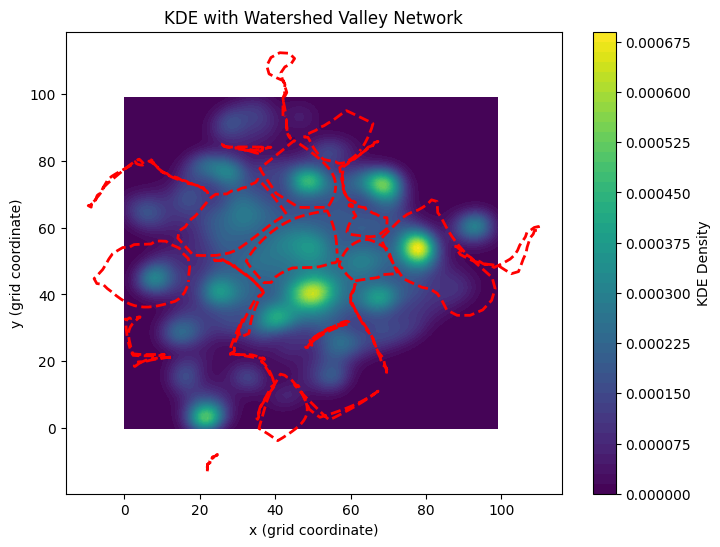

In [519]:
plot_watershed_valleys(kde_results)

(array([3794.,  385., 1020., 3537.,  883., 1808.,  995.,  614.,  173.,
          27.]),
 array([0.        , 0.25788301, 0.51576601, 0.77364902, 1.03153203,
        1.28941504, 1.54729804, 1.80518105, 2.06306406, 2.32094707,
        2.57883007]),
 <BarContainer object of 10 artists>)

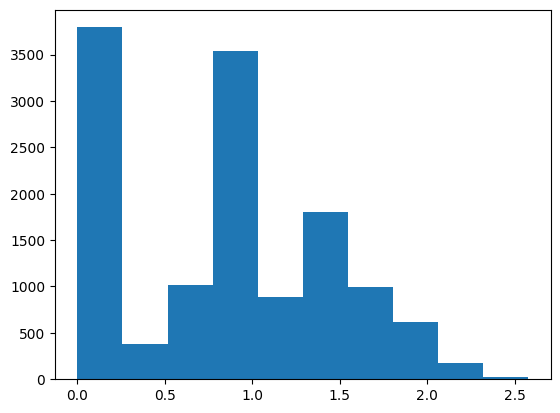

In [383]:
plt.hist(enriched_df.groupby("u_id").first()['user_basin_entropy'])

In [370]:
tx_analysis = analyze_basin_transitions(enriched_df)

/tmp/ipykernel_1644527/3641163923.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5489081663176787' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transition_probs.loc[basin] = transition_counts.loc[basin] / row_sums[basin]
/tmp/ipykernel_1644527/3641163923.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0008973975471133712' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transition_probs.loc[basin] = transition_counts.loc[basin] / row_sums[basin]
/tmp/ipykernel_1644527/3641163923.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.002991325157044571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  t

In [371]:
tx_analysis[0]

0.0       1.0       2.0       3.0       4.0       5.0       6.0   \
0.0   0.548908  0.000897  0.000000  0.002991  0.020042  0.000000  0.014358   
1.0   0.000000  0.468495  0.000583  0.027421  0.019253  0.000000  0.081097   
2.0   0.000000  0.000000  0.100000  0.066667  0.216667  0.000000  0.108333   
3.0   0.003361  0.004901  0.000840  0.583812  0.102787  0.000000  0.109929   
4.0   0.005655  0.002121  0.002121  0.063227  0.547282  0.000000  0.113258   
5.0   0.000000  0.000000  0.000000  0.000000  0.003210  0.667737  0.276083   
6.0   0.002395  0.006056  0.000411  0.026313  0.046741  0.005851  0.588435   
7.0   0.016293  0.009015  0.000566  0.018267  0.036417  0.000053  0.109500   
8.0   0.000152  0.000000  0.000000  0.000762  0.028506  0.004268  0.019817   
9.0   0.000000  0.000000  0.000000  0.000000  0.477876  0.008850  0.079646   
10.0  0.000000  0.000000  0.000000  0.000897  0.000897  0.000000  0.167713   
11.0  0.000790  0.002765  0.000395  0.005529  0.013823  0.000000  0.062401   
12.0  0.001178  0.000196  0.001079  0.003925  0.013639  0.000000  0.033853   
13.0  0.001808  0.001206  0.001206  0.003617  0.019289  0.000000  0.059675   

          7.0       8.0       9.0       10.0      11.0      12.0      13.0  
0.0   0.410111  0.000299  0.000000  0.000000  0.001795  0.000598  0.000000  
1.0   0.398483  0.000000  0.000000  0.000000  0.001167  0.002334  0.001167  
2.0   0.366667  0.000000  0.000000  0.000000  0.000000  0.125000  0.016667  
3.0   0.183588  0.000840  0.000000  0.000140  0.001540  0.006722  0.001540  
4.0   0.222667  0.015473  0.004948  0.000079  0.003299  0.016808  0.003063  
5.0   0.006421  0.043339  0.000000  0.003210  0.000000  0.000000  0.000000  
6.0   0.289649  0.004209  0.000308  0.006228  0.007049  0.012489  0.003867  
7.0   0.763075  0.001724  0.000158  0.000066  0.016214  0.023269  0.005383  
8.0   0.017378  0.923476  0.003811  0.001372  0.000000  0.000305  0.000152  
9.0   0.097345  0.238938  0.088496  0.000000  0.000000  0.008850  0.000000  
10.0  0.003587  0.012556  0.000000  0.814350  0.000000  0.000000  0.000000  
11.0  0.473144  0.000790  0.000000  0.000000  0.230648  0.152844  0.056872  
12.0  0.159847  0.000196  0.000000  0.000098  0.040722  0.674713  0.070552  
13.0  0.226643  0.000603  0.000000  0.000603  0.093430  0.428571  0.163351

<Axes: >

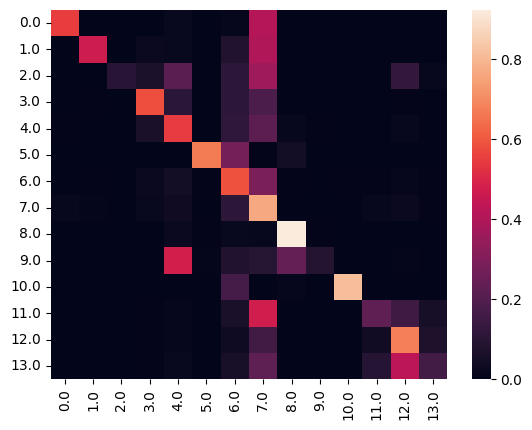

In [372]:
import seaborn as sns
sns.heatmap(tx_analysis[0])

In [335]:
analyzer.clean_disconnected_basins(min_component_size=20)

Basin 0 has 13 disconnected components
Basin 1 has 2 disconnected components
Basin 2 has 2 disconnected components
Basin 4 has 2 disconnected components
Basin 7 has 8 disconnected components
Basin 9 has 3 disconnected components
Basin 11 has 2 disconnected components
  Pruned component of basin 0 with 1 cells, assigned to basin 9
  Pruned component of basin 0 with 5 cells, assigned to basin 9
  Pruned component of basin 0 with 2 cells, assigned to basin 9
  Pruned component of basin 0 with 5 cells, assigned to basin 9
  Pruned component of basin 0 with 8 cells, assigned to basin 9
  Pruned component of basin 0 with 1 cells, assigned to basin 9
  Pruned component of basin 0 with 3 cells, assigned to basin 9
  Pruned component of basin 0 with 18 cells, assigned to basin 9
  Pruned component of basin 0 with 2 cells, assigned to basin 9
  Pruned component of basin 0 with 2 cells, assigned to basin 9
  Pruned component of basin 0 with 10 cells, assigned to basin 9
  Pruned component of basi

<Figure size 1200x1000 with 0 Axes>

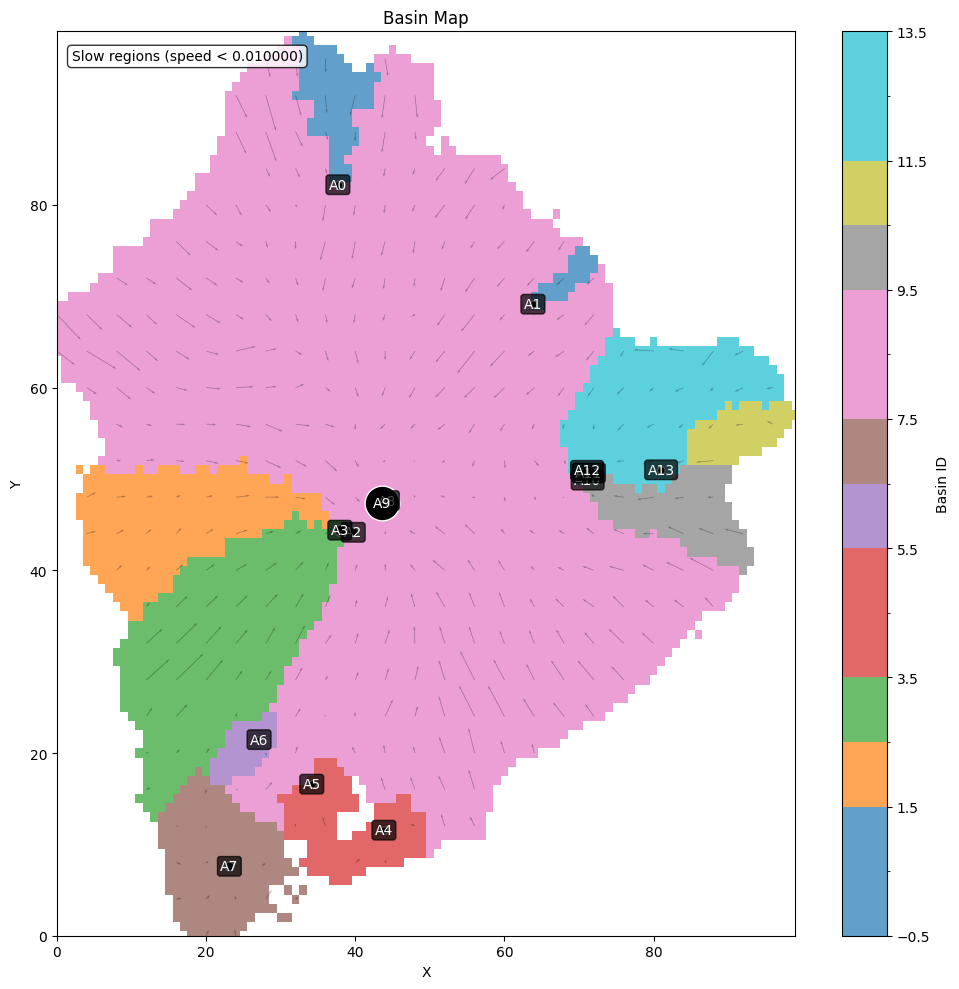

In [336]:
plt.figure(figsize=(12, 10))
analyzer.plot_basin_heatmap(
    cmap='tab10',
    show_attractors=True,
    show_vector_field=True,
    vector_density=4,
    slow_region_threshold=0.01  # Highlight regions slower than this threshold
)
plt.tight_layout()

In [184]:
import skimage.morphology as morph

def fill_basins_by_dilation(analyzer, dilation_iterations=2):
    """
    Fill basin interiors using binary dilation with smaller basins layered on top.
    
    Parameters:
    -----------
    analyzer : TrajectoryAnalysis
        The trajectory analysis object with basin_grid attribute
    dilation_iterations : int
        Number of dilation iterations to perform
        
    Returns:
    --------
    numpy.ndarray
        The updated basin grid (without modifying analyzer.basin_grid)
    """
    # Store original basin grid for comparison
    original_basin_grid = analyzer.basin_grid.copy()
    
    # Get unique basin IDs (excluding -1)
    basin_ids = np.unique(original_basin_grid[original_basin_grid != -1])
    
    # Calculate size of each basin
    basin_sizes = {}
    for basin_id in basin_ids:
        basin_sizes[basin_id] = np.sum(original_basin_grid == basin_id)
    
    # Sort basin IDs by size (smallest to largest)
    sorted_basin_ids = sorted(basin_sizes.keys(), key=lambda x: basin_sizes[x])
    
    print("Basins ordered by size (smallest to largest):")
    for basin_id in sorted_basin_ids:
        print(f"  Basin {basin_id}: {basin_sizes[basin_id]} cells")
    
    # Create a new basin grid starting with the original assignments
    new_basin_grid = original_basin_grid.copy()
    
    # Create a mask of cells that already have assignments
    assigned_mask = (original_basin_grid != -1)
    
    # Process basins from largest to smallest (bottom to top)
    for basin_id in reversed(sorted_basin_ids):
        # Create a binary mask for this basin from the original grid
        basin_mask = (original_basin_grid == basin_id)
        
        # Dilate the basin mask
        
        dilated_mask = morph.binary_dilation(basin_mask, morph.disk(1))
        if dilation_iterations > 1:
            for i in range(dilation_iterations-1):
                dilated_mask = morph.binary_dilation(dilated_mask, morph.disk(1))
        
        # Only fill in cells that don't already have assignments
        fill_mask = dilated_mask & ~assigned_mask
        
        # Apply the mask to the new basin grid
        new_basin_grid[fill_mask] = basin_id
        
        # Update the assigned mask
        assigned_mask = assigned_mask | fill_mask
    
    # Count how many cells were filled
    filled_count = np.sum(new_basin_grid != -1) - np.sum(original_basin_grid != -1)
    print(f"Basin dilation: {filled_count} additional cells assigned to basins")
    
    return new_basin_grid

new_grid = fill_basins_by_dilation(analyzer)

Basins ordered by size (smallest to largest):
  Basin 9: 7 cells
  Basin 10: 16 cells
  Basin 4: 26 cells
  Basin 8: 50 cells
  Basin 7: 59 cells
  Basin 5: 66 cells
  Basin 6: 163 cells
  Basin 2: 211 cells
  Basin 3: 538 cells
  Basin 1: 816 cells
  Basin 0: 3664 cells
Basin dilation: 857 additional cells assigned to basins


<Figure size 1200x1000 with 0 Axes>

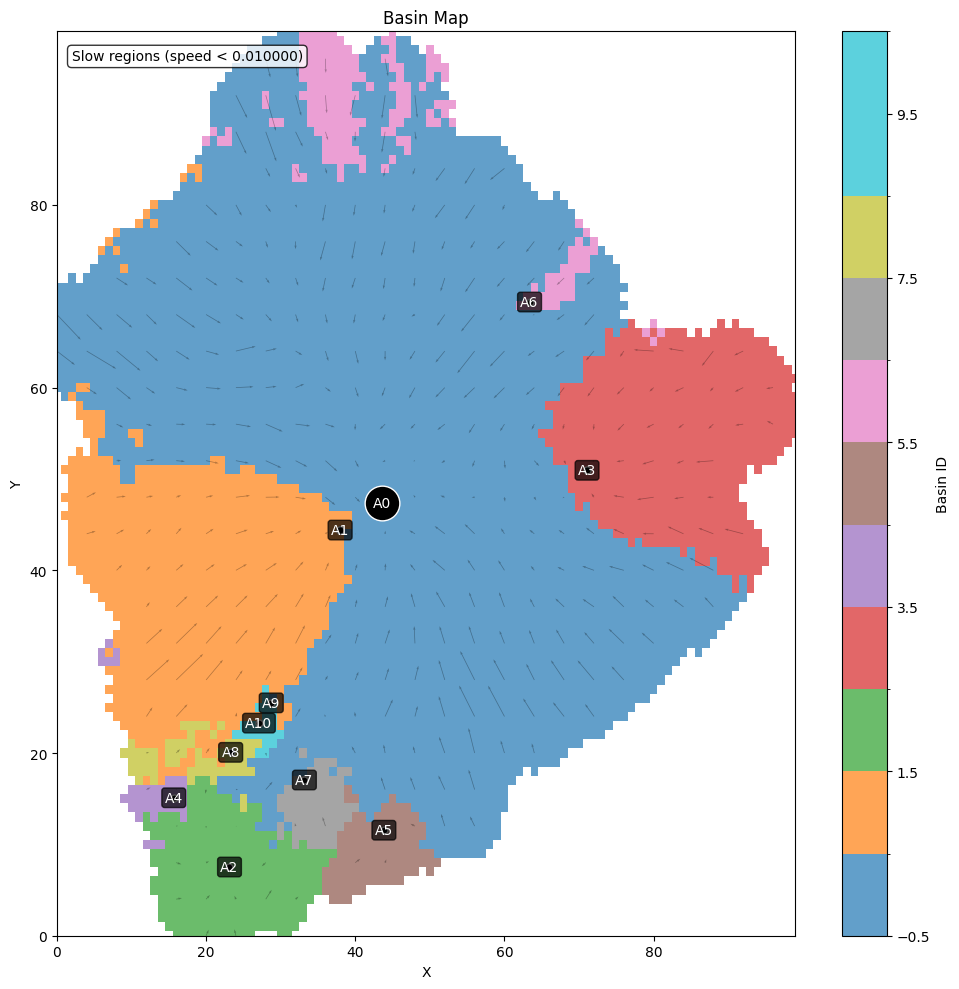

In [185]:
analyzer.basin_grid = new_grid
# Create a visualization with basins, attractors, and vector field overlay
plt.figure(figsize=(12, 10))
analyzer.plot_basin_heatmap(
    cmap='tab10',
    show_attractors=True,
    show_vector_field=True,
    vector_density=4,
    slow_region_threshold=0.01  # Highlight regions slower than this threshold
)
plt.tight_layout()

<Axes: xlabel='X', ylabel='Y'>

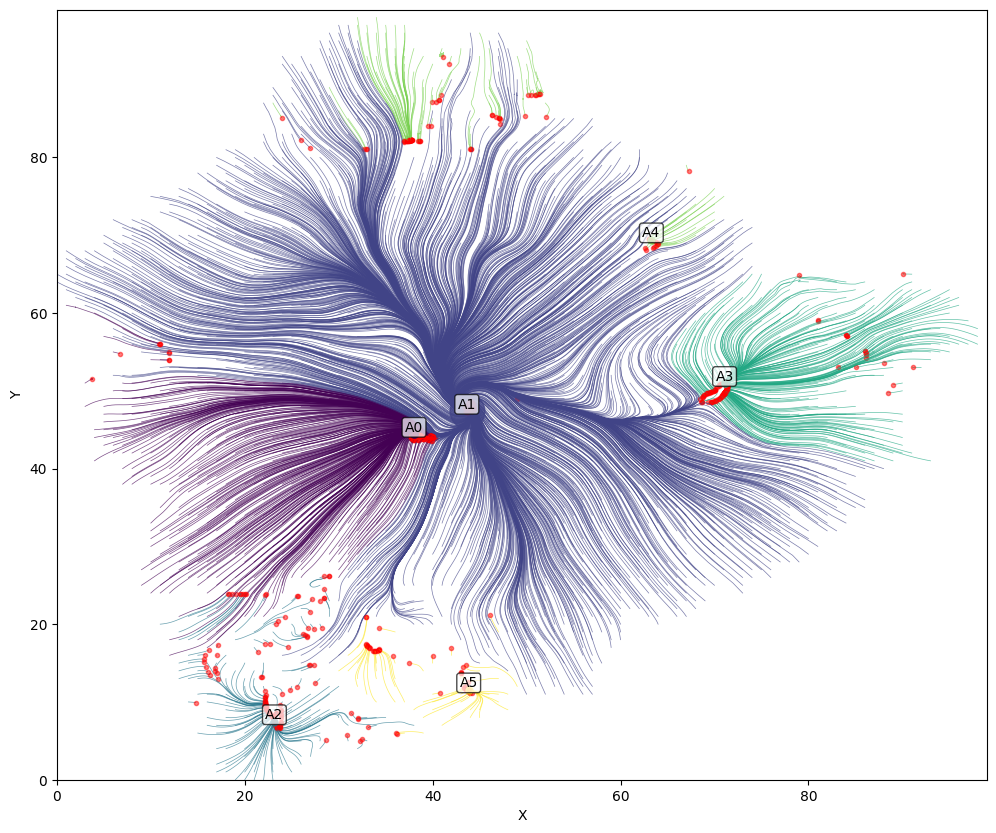

In [201]:
analyzer.plot_trajectories(sample_factor=1,show_endpoints=True,color_by_basin=True)

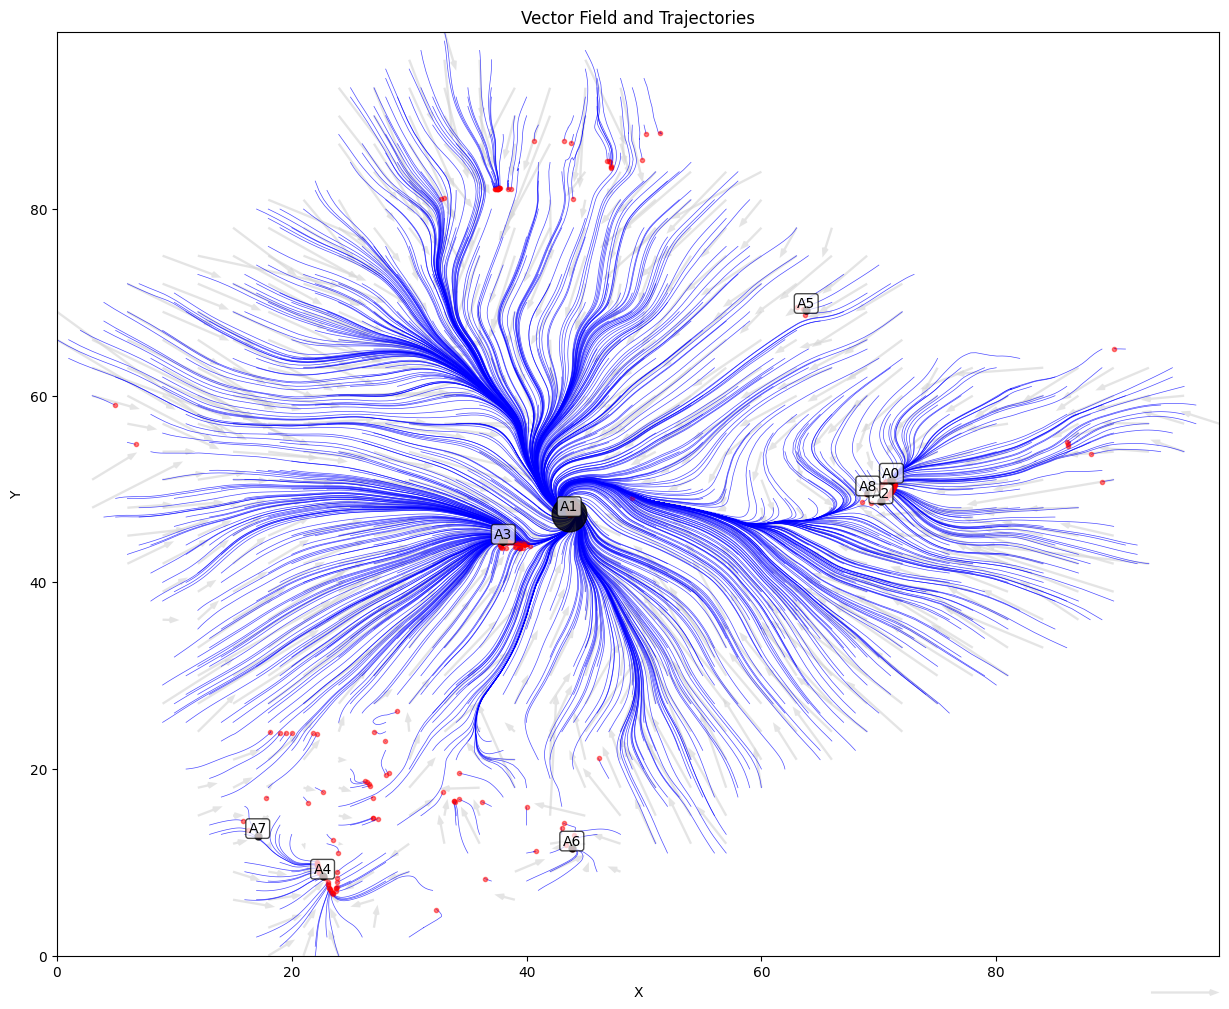

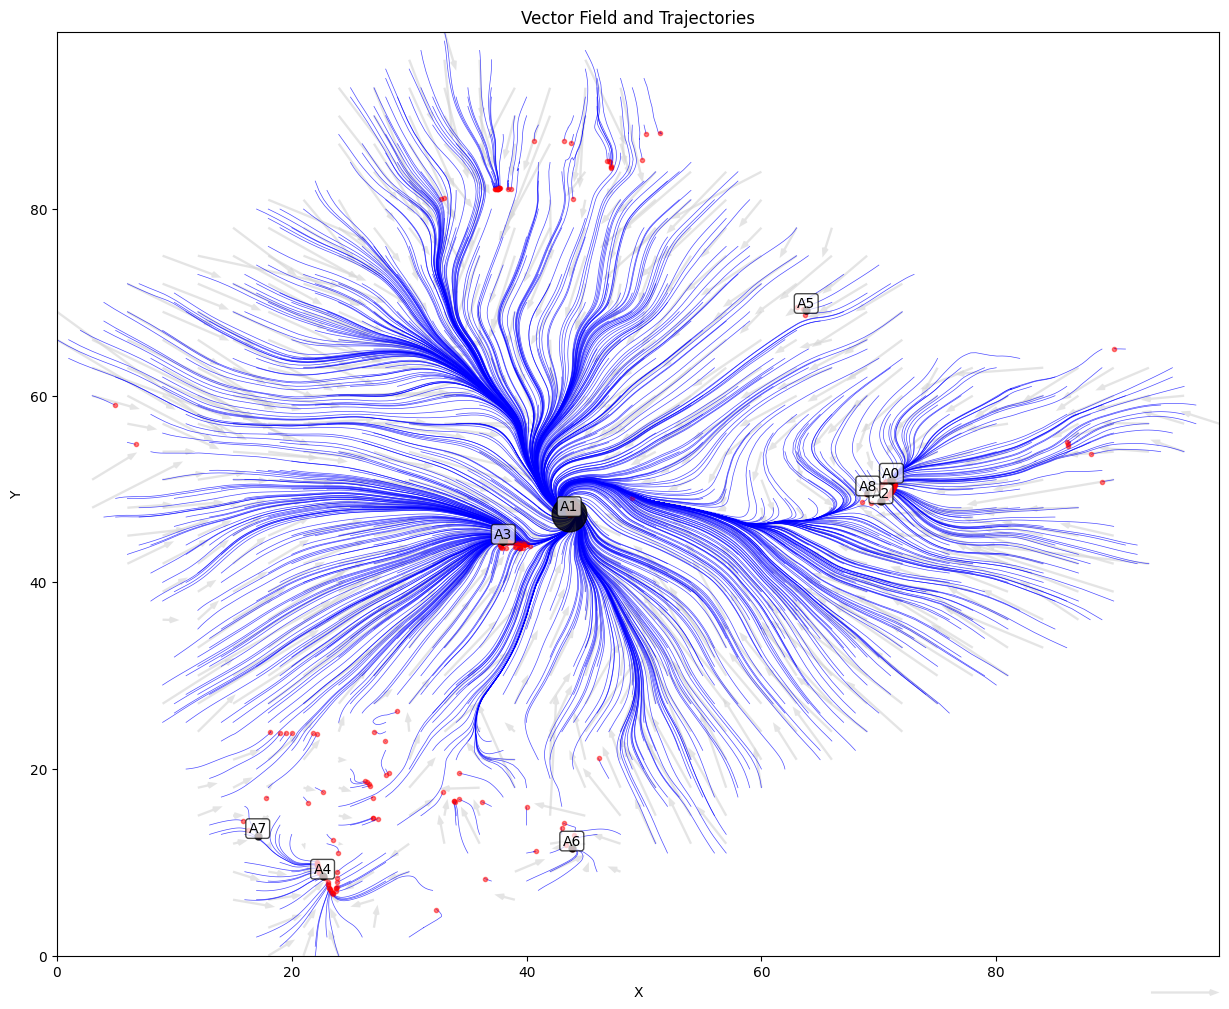

In [116]:
analyzer.plot_combined(sample_factor=1)

In [99]:
analyzer.basins

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

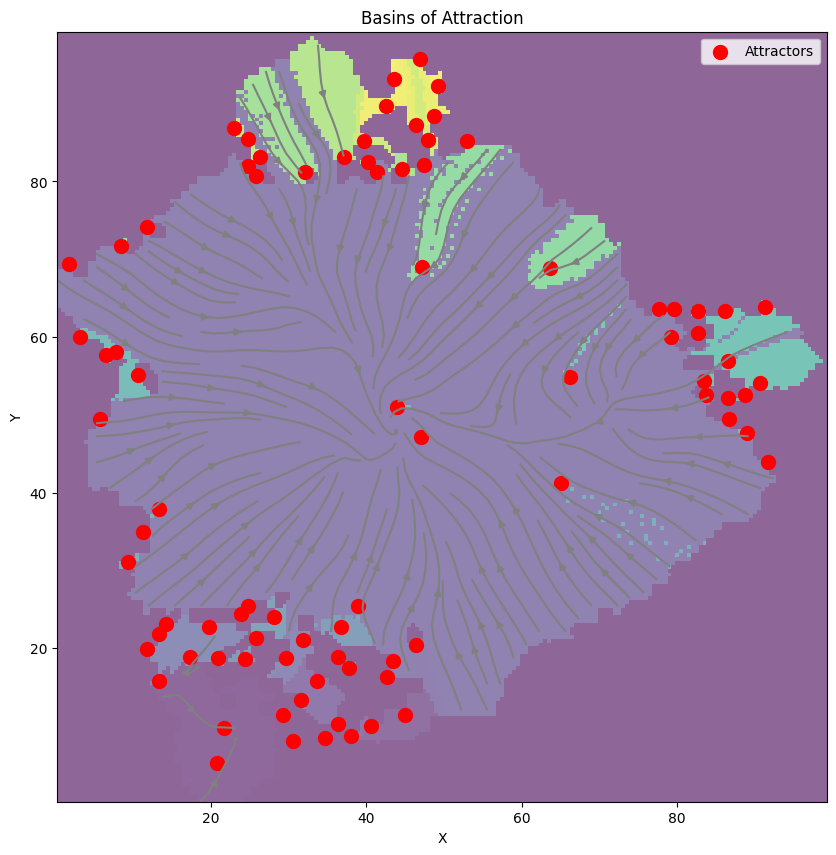

In [77]:
analyzer.plot_basins()

In [88]:
analyzer_2 = TrajectoryBasedAttractorAnalyzer(averaged, interpolation_factor=2)
trajectories = analyzer_2.analyze_vector_field()

attractors, basins = analyzer_2.find_attractors_and_basins(trajectories)

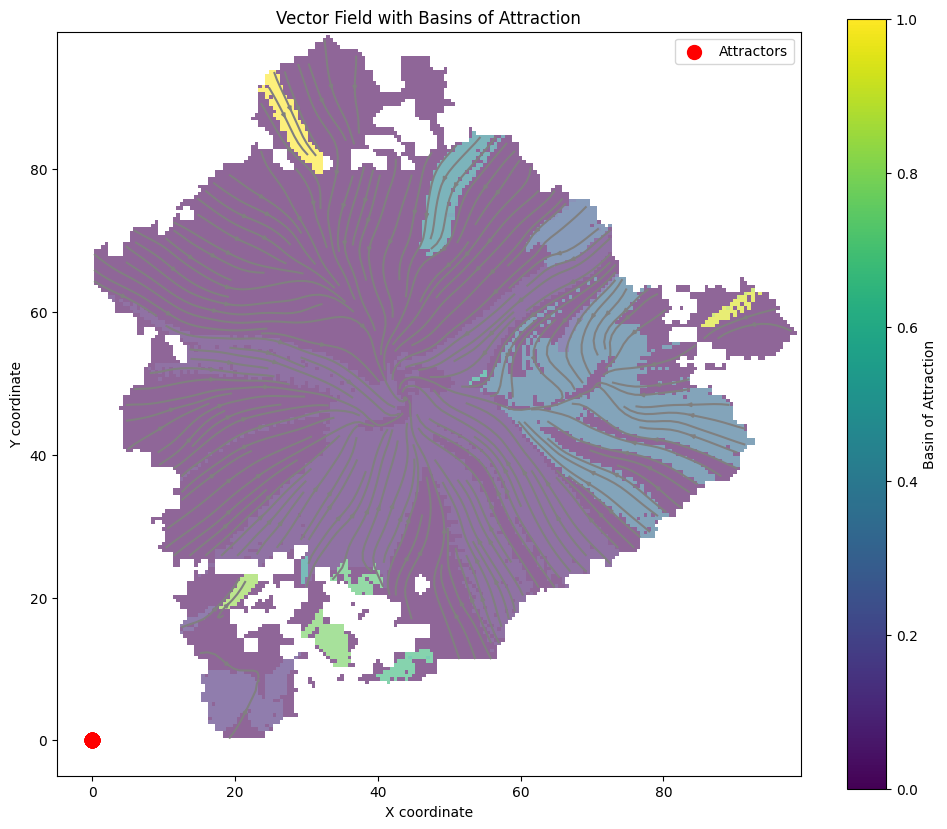

In [96]:
analyzer_2.plot_results(np.zeros(basins.shape),basins)

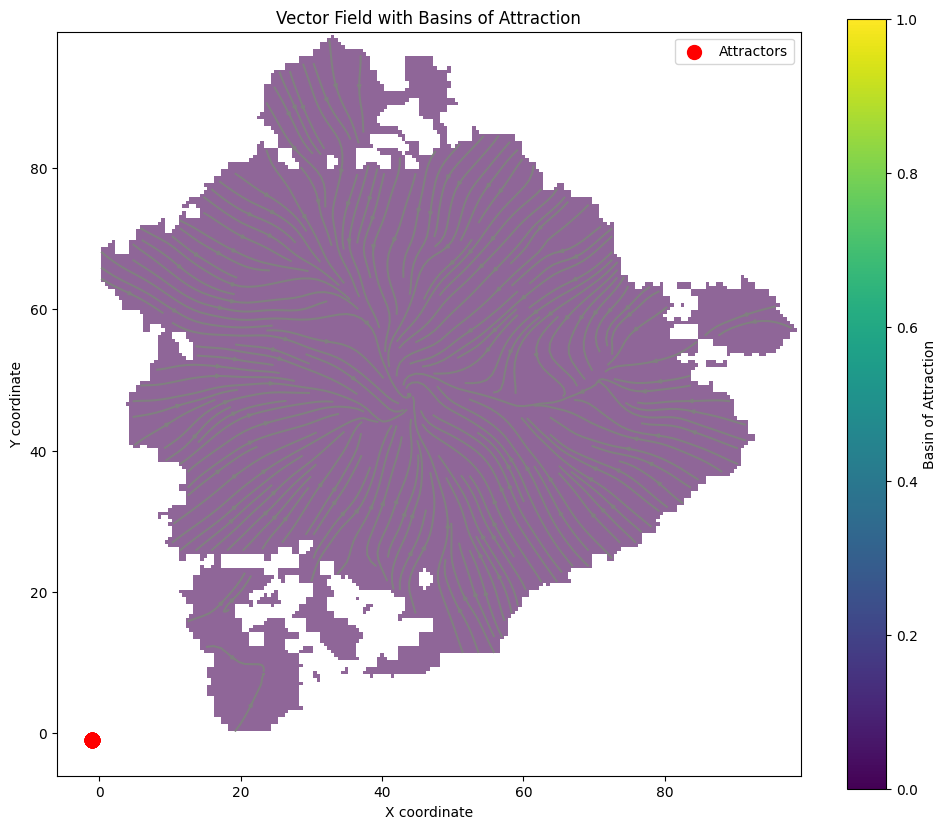

In [92]:
analyzer_2.plot_results(basins,np.zeros(basins.shape))

In [48]:
#Old version
# analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=2)
# trajectories = analyzer.analyze_vector_field(step_size=.1)
# attractors, basins = analyzer.find_attractors_and_basins(trajectories,min_quality=500,threshold=.6,samples=10)

analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=2)

attractors, basins = analyzer.analyze_field(
    sensitivity=1.0,          # Controls trajectory generation precision
    min_samples=5,           # Minimum trajectories for an attractor cluster
    similarity_threshold=0.7  # How similar trajectories need to be to cluster
)

KeyboardInterrupt: 

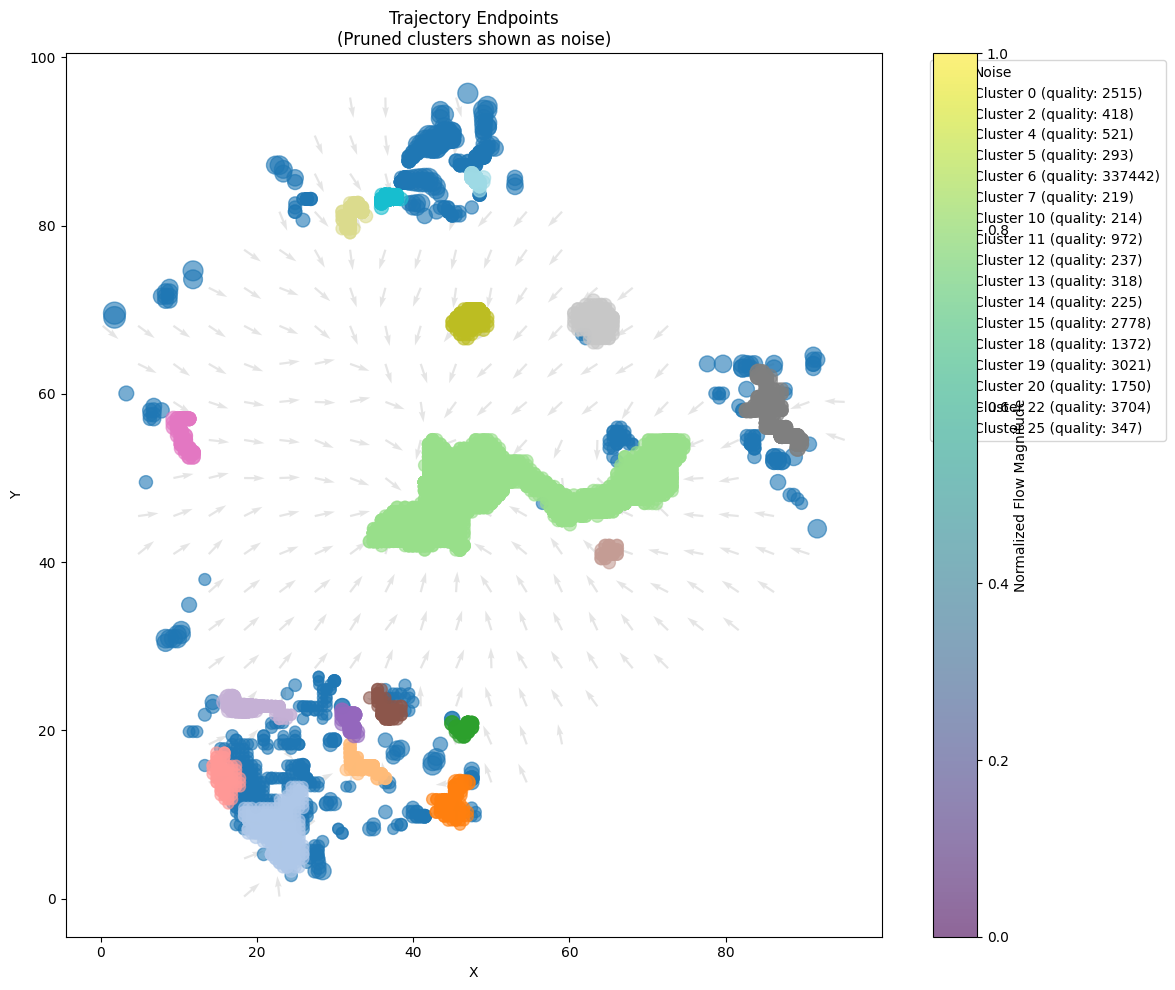

In [44]:
analyzer.plot_trajectory_endpoints()

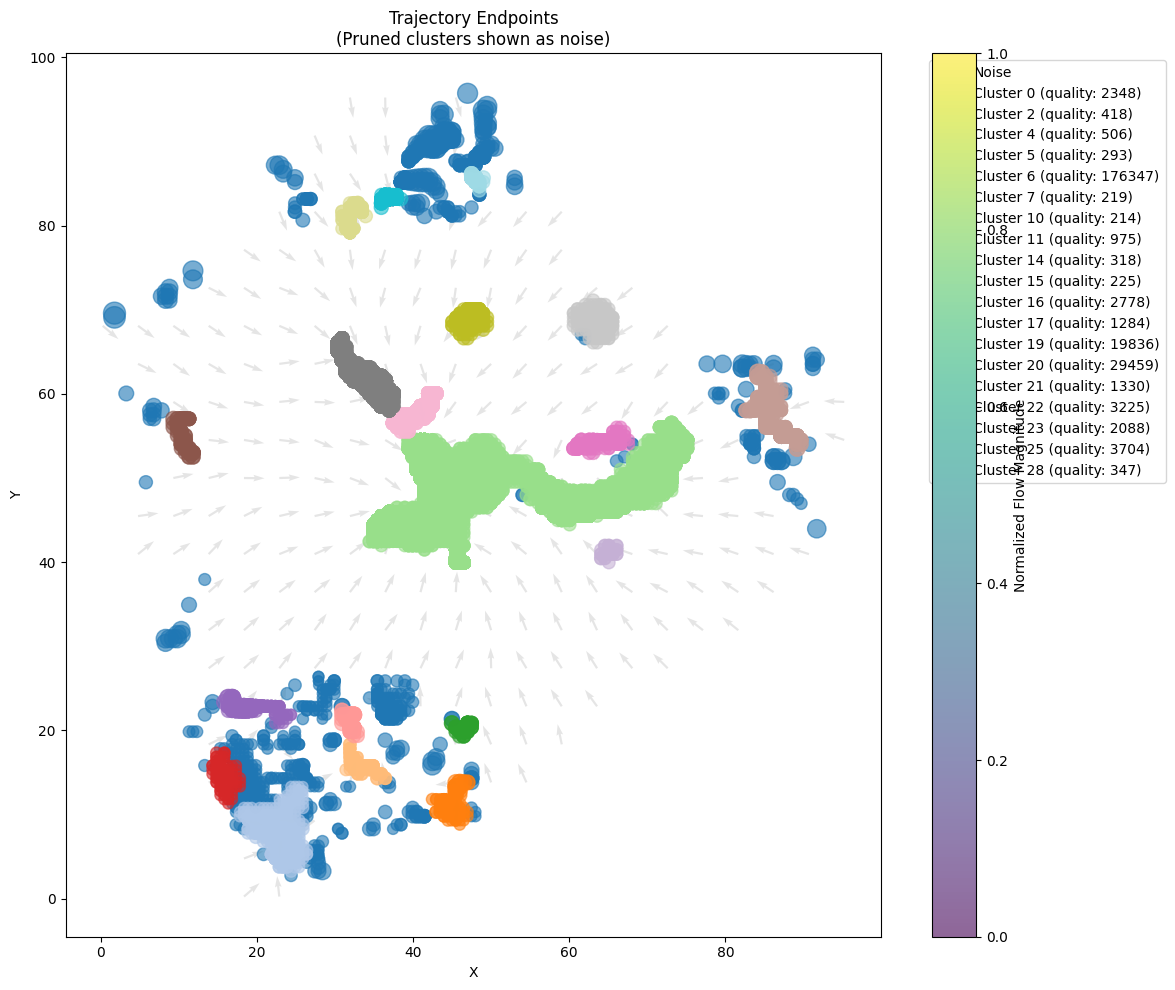

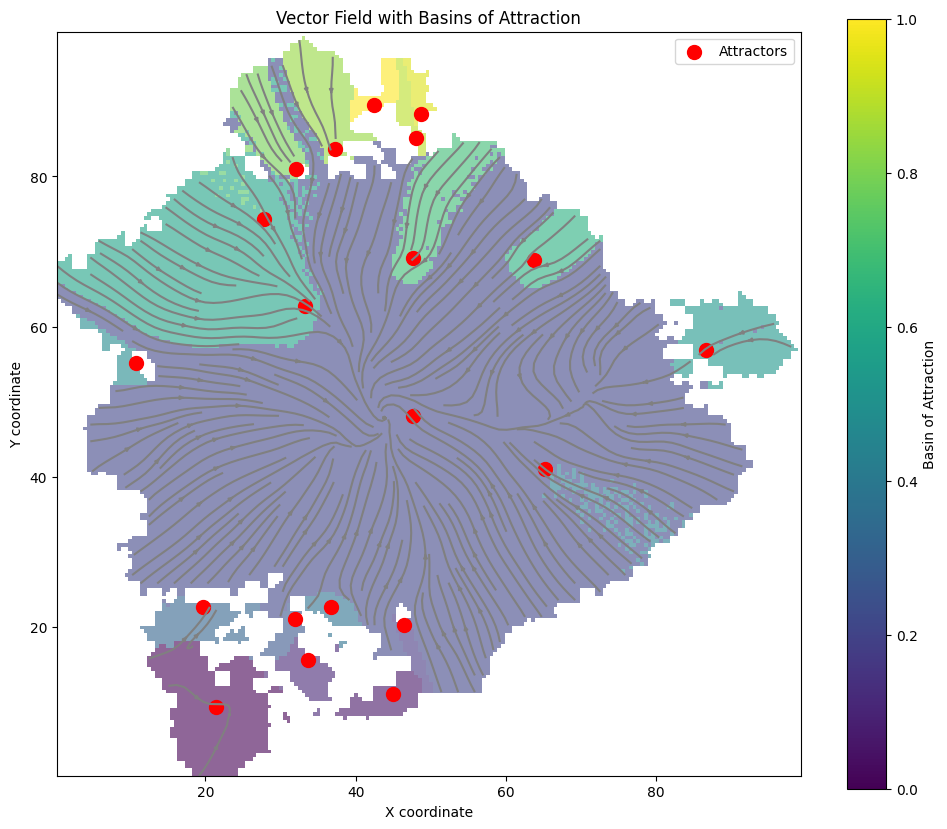

In [34]:
analyzer.plot_results(attractors, basins)